In [8]:
import numpy as np
from astropy.io import fits
import glob
import matplotlib.pyplot as plt
# %matplotlibinline
import os
from pathlib import Path
import sys
plt.style.use('seaborn-v0_8-darkgrid')
import pandas
from astropy.modeling import models, fitting
from astropy import modeling
from scipy.signal import savgol_filter
#---------------------------------------------------------------
import matplotlib
import timeit
import os
from pathlib import Path
import sys
import time
import numpy as np
from math import floor
from random import choice
import csv
import pandas as pd
from scipy import constants
from scipy import interpolate
from scipy import optimize
from scipy import stats
from scipy import ndimage
from scipy.optimize import curve_fit
from scipy.stats import pearsonr
matplotlib.rcParams.update({'font.size': 18})
from tools import *
from pathlib import Path

# from tools import findel
# from tools import airtovac
# from tools import gauss
# from tools import gauss_line
# from tools import parabola
# from tools import compare_lines1
# from tools import blaze_correct
# from tools import reverse_blaze
# from tools import wave_vel_shift
# from tools import make_temps

# Read in spectra .fits files

In [11]:
Path.home()

PosixPath('/Users/kehrich')

In [13]:
# home = str(Path.home())

#grab .fits files from directory
local_path = os.getcwd()
#spec_fits_directory = '/Users/kehrich/Downloads/neid_solar_test/solar_data/merge_folder/files_for_temps'
spec_fits_directory = os.path.join(local_path, 'neid_solar_data')
spec_path = spec_fits_directory
spec_fits_files0 = [i for i in glob.glob(os.path.join(spec_path, '*.fits'))]
print(len(spec_fits_files0))
print(spec_path)

#pull Julian Dates from each .fits file
days = []
for ind, file in enumerate(spec_fits_files0):
    day= np.round(fits.getheader(file)['OBSJD'])
    days.append(day)

54
/Users/kehrich/Downloads/machine_learning_final_project/neid_solar_data


In [15]:
#create array of each unique date
uniques = np.unique(days)

#create list of files from each day to create templates
sort_files = []
for uind, uniq in enumerate(uniques):
    inds_vals = np.where(np.asarray(days).astype(int) == int(uniq))
    sort_files.append(np.asarray(spec_fits_files0)[inds_vals[0]])
    

In [17]:
line_list = 'new_gurtovenko_2015.csv'
file = line_list
dict_linelist = pandas.read_csv(file,delimiter='&')
dict_linelist

lambda (nm)      element    EP (eV)    depth   deltazeff (km)   \
0          670.77     Li I           0.00    0.010             109    
1          313.10     Be II          0.00    0.720             129    
2          481.73     C I            7.48    0.138              60    
3          505.21     C I            7.68    0.252              63    
4          538.03     C I            7.68    0.158               62   
..            ...          ...        ...      ...              ...   
498        525.55     Nd II          0.20    0.092             137    
499        446.73     Sm II          0.66    0.137           130      
500        452.39     Sm II          0.43    0.124           133      
501        407.31     Dy II          0.54    0.120            127     
502        368.34     Pb I           0.97    0.165            115     

           I_l         D_l       I_l/2    D_l/2          I_c \\  
0        -0.147     -1.180       -0.146   -1.132    -0.144   \\  
1        -0.193      -1.238       0.098   -0.772     0.181   \\  
2        -0.139     -0.253      -0.051    -0.139     0.047   \\  
3        -0.361     -0.411      -0.180    -0.207     0.015   \\  
4        -0.274     -0.337      -0.157    -0.193     -0.025  \\  
..          ...         ...         ...      ...            ...  
498    -0.042       -1.333     -0.026     -1.253      -0.011 \\  
499    0.057      -1.191       0.080      -1.096       0.100 \\  
500    0.055      -1.229       0.074      -1.140       0.091 \\  
501    0.134       -1.101       0.150     -1.025       0.166 \\  
502    0.211       -1.232       0.224     -1.149       0.236 \\  

[503 rows x 10 columns]

In [19]:
dict_linelist.keys()

Index(['lambda (nm) ', ' element ', ' EP (eV) ', ' depth ', ' deltazeff (km) ',
       ' I_l ', ' D_l ', ' I_l/2 ', ' D_l/2 ', ' I_c \\'],
      dtype='object')

# There are 3 solar files per day, average them to create a template for each day for higher SNR while running thru pipeline and to eliminate data gaps. A template is just an averaged spectrum.

In [22]:
def make_temps2(sort_files):
    '''Creates a template for each day
    
    Inputs
    --------------
    sort_files: list
        list of files from same day within larger list which will be used to create each template
    
    Outputs
    --------------
    templates: list
        list of templates with one template per day
    masterwaves: list
        list of wavelengths to be used in conjunction with template fluxes
        
    K Ehrich - JPL - 18-Jul-2022 -- Parts of code created by Abigail Burrows
    '''

    for jd_ind, spec_fits_files in enumerate(sort_files):
        #---------------------------Master Wavelength----------------------------------
        # find average measured_rv
        print(jd_ind,'/',len(sort_files))
        avg_ccfrv = 0
        num_files = 0
        for file in spec_fits_files:
            ccf_header = fits.getheader(file, 'CCFS')
            measured_rv = ccf_header['CCFRVMOD']
            avg_ccfrv += measured_rv
            num_files += 1
        avg_ccfrv = avg_ccfrv/num_files
        # first, make the master_wavelengths file
        wave_master = fits.getdata(spec_fits_files[0], 'SCIWAVE') / 10.
        # red-shift each spectrum to account for the barrycentric velocity
        # shift: lambda_rest = lambda_obs / (1+v/c)
        # pull velocity information from header -- this is from neid_measure_act slash this is how we were shifting for velocity offset there
        hdr_spec = fits.getheader(spec_fits_files[0])
        ccf_header = fits.getheader(spec_fits_files[0],'CCFS')

        bc_vel = hdr_spec['SSBRV160'] # km/s
        q_vel = hdr_spec['QRV'] # km/s
        measured_rv = ccf_header['CCFRVMOD']

        # shift wavelengths to stellar rest frame
        vel_factor = -1. * (float(bc_vel) + float(q_vel) + float(measured_rv)) - avg_ccfrv

        # shift factor
        z = (1-((vel_factor*10**3)/constants.c))

        # shift wave
        wave_master = wave_master * z # or is it wave/z ?
        # print(wave_master[50][3000:3016])
        #----------------------------Initialize Template Array---------------------------------
        template = np.zeros(np.shape(wave_master))
        #----------------------------Loop---------------------------------
        # For each file: blaze correct, cut out the first 1000 and last 1000 pixels
        hasblaze = 0
        noblaze = 0
        for fits_file in spec_fits_files:
            main_header = fits.getheader(fits_file)
            #if main_header['DRIFTFUN'] == 'simultaneous' and main_header['WAVECAL'] == 'LFCplusThAr': # trying to take out bad days
            if True:
                #----------------------------Read In---------------------------------
                # read in wave, spec, and var
                # the actual spectrum (in flux units)
                flux = fits.getdata(fits_file, 'SCIFLUX')

                # the variance or noise of the spectrum
                var = fits.getdata(fits_file, 'SCIVAR')

                # the wavelength solution of the spectrum
                wave = fits.getdata(fits_file, 'SCIWAVE') / 10. # nm

                if np.shape(flux) == (122, 9216):
                    while True:
                        try:
                            blaze = fits.getdata(fits_file, 'SCIBLAZE')
                            hasblaze += 1
                            break
                        except KeyError:
                            #print(fits_file)
                            noblaze += 1
                            blaze = np.array((10,10))
                            break
                    #---------------------------Clean NaN orders----------------------------------
                    # get rid of NaN orders, if any
                    # get order mean wavelengths
                    nord = flux.shape[0]
                    wvls_ord = []

                    # get mean order wavelengths
                    for ind, order in enumerate(range(nord)):
                        wvls_ord.append(np.nanmean(wave[ind,:]))
                    wvls_ord = np.asarray(wvls_ord)

                    # now cut the nan orders
                    nan_ords = np.isnan(wvls_ord)
                    #----------------------------Blaze correct and cut---------------------------------
                    # blaze correct each spectrum, cut out the first and last, and save
                    if np.shape(blaze) != np.shape(flux):
                        for i in range(len(flux)):
                            if not nan_ords[i]:
                                wvl_ord = wave[i]
                                try:
                                    flux_ord = blaze_correct(i,wave,flux)
                                except TypeError:
                                    print('Skipped because missing argument')
                                    print(fits_file)
                                #flux_ord = flux[i] / blaze[i]
                                if i == 50:
                                    plt.scatter(wvl_ord, flux_ord)
                                flux_ord = flux_ord / ndimage.maximum_filter1d(flux_ord, 3, axis=- 1, output=None, mode='reflect', cval=0.0, origin=0)
                            else:
                                wvl_ord = wave[i]
                                flux_ord = flux[i]
                            wave[i] = wvl_ord
                            flux[i] = flux_ord
                    else:
                        for i in range(len(flux)):
                            if not nan_ords[i]:
                                wvl_ord = wave[i]
                                #flux_ord = blaze_correct(i,wave,flux)
                                percentile_flux = np.nanpercentile(flux[i,:], 95)
                                flux_ord = flux[i] / blaze[i]
                                #flux_ord = flux_ord / ndimage.maximum_filter1d(flux_ord, 3, axis=- 1, output=None, mode='reflect', cval=0.0, origin=0)
                                flux_ord = flux_ord*percentile_flux
                            else:
                                wvl_ord = wave[i]
                                flux_ord = flux[i]
                            wave[i] = wvl_ord
                            flux[i] = flux_ord
                    #-------------------------------Shift into Star's RF------------------------------
                    # red-shift each spectrum to account for the barrycentric velocity
                    # shift: lambda_rest = lambda_obs / (1+v/c)
                    # pull velocity information from header -- this is from neid_measure_act slash this is how we were shifting for velocity offset there
                    hdr_spec = fits.getheader(fits_file)
                    ccf_header = fits.getheader(fits_file,'CCFS')

                    bc_vel = hdr_spec['SSBRV160'] # km/s # 'Barycentric corr. (km/s) for order 160' why do you take the 160th order? # barrycentric correction for each order WE CAN USE ONE FOR ALL ORDERS BC SUN
                    q_vel = hdr_spec['QRV'] # km/s # 'Queue RV for Star'
                    measured_rv = ccf_header['CCFRVMOD'] # 'Bary. corrected RV for weighted orders' -- this is the actual RV

                    # shift wavelengths to stellar rest frame
                    vel_factor = -1. * (float(bc_vel)) + float(q_vel) + float(measured_rv) - avg_ccfrv
                    # add a 7.55 for the otherstar -- add a variable for adding extra velocity correction?
                    # add .675 for the sun -- trying to get closer from the start (may need to add this to the template but try this first)


                    # shift factor
                    z = (1-((vel_factor*10**3)/constants.c))
                    z_file = (1+hdr_spec['SSBZ060'])

                    # shift wave
                    wave = wave * z # or is it wave/z ?
                    #wave = wave*z_file
                    #------------------------------Interpolate with Master Wavelengths-------------------------------
                    for ind in range(len(wave)):
                        f = interpolate.interp1d(wave[ind], flux[ind], fill_value="extrapolate")# can only use the fill value if your new values are BARELY out of range
                        flux[ind] = f(wave_master[ind])
                        wave[ind] = wave_master[ind]

                        # cut flux
                        flux[ind][0:1000] = np.nan
                        flux[ind][8000:] = np.nan

                        # cut variance
                        var[ind][0:1000] = np.nan
                        var[ind][8000:] = np.nan
                        #------------------------------Add to template-------------------------------
                        template[ind] += flux[ind]
                        
        # save each template to .csv file
        local_path = os.getcwd()
        templatePath = os.path.join(local_path, f'test_temp{uniques[jd_ind]}.csv')
        with open(templatePath,"w+") as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(template)
            
        # save each masterwave to a .csv file
        masterwavePath = os.path.join(local_path, f'test_wave{uniques[jd_ind]}.csv')
        with open(masterwavePath,"w+") as my_csv:
            csvWriter = csv.writer(my_csv,delimiter=',')
            csvWriter.writerows(wave_master)    
                        
        # read in template
        template = np.loadtxt(open(templatePath, "rb"), delimiter=",")

        # read in masterwave
        masterwave = np.loadtxt(open(masterwavePath, "rb"), delimiter=",")
        

    return template, masterwave

# Now actually creating the template per day, along with a master wavelength solution

In [32]:
local_path = os.getcwd()
templates, masterwaves = make_temps2(sort_files)

0 / 18


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/254572208.py:123: RuntimeWarning: invalid value encountered in divide
  flux_ord = flux[i] / blaze[i]
/opt/anaconda3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/opt/anaconda3/lib/python3.11/site-packages/scipy/interpolate/_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


1 / 18
2 / 18
3 / 18
4 / 18
5 / 18
6 / 18
7 / 18
8 / 18
9 / 18
10 / 18
11 / 18
12 / 18
13 / 18
14 / 18
15 / 18
16 / 18
17 / 18


In [34]:
# Converts air wavelengths to vacuum wavelengths
def airtovac(wvl_air):
    s = 104 / wvl_air
    n = 1 + 0.00008336624212083 + 0.02408926869968 / (130.1065924522 - s**2) + 0.0001599740894897 / (38.92568793293 - s**2)
    wvl_vac = wvl_air * n  
    return wvl_vac

# Below is the pipeline which matches observed spectral lines to theoretical lines from the provided linelist, so we can see what species they are and can link physics to observed variations. This pipeline also measures observed line parameters so we can correlate against their shape variations over time.

In [37]:
def compare_lines1(run, line_list, wavelengths, flux, obs_jd, maxima_dict = {}, init_window_wid=0.3, blaze_correct=False, vac=True):
    '''
    Compares line lists to empirical data and returns parameters and characteristics for each line.
    
    Inputs
    ------
    run : 'int'
        run #, used to create unique filenames
    line_list : .csv file
        list of lines to compare to empirical data
    wavelengths : list
        list of empirical stellar spectral wavelength data, parsed to find 
        corresponding lines in line_list
    flux : list
        list of empirical stellar spectral flux data, corresponds to wavelength list
    maxima_dict : dictionary
        dictionary in the format as follows: {empirical_line : left_bound, right bound};
        if empty, boundaries will be computed by peak finding, else provided bounds will be used
    init_window_wid : 'float'
        sets initial window width to match theoretical line with empirical line in terms of 
        wavelength in Angstrom, default = 0.03
    blaze_correct : 'False' or list
        if list provided, flux will be flattened using blaze function; default = 'False'
    vac : Boolean--'True' or 'False'
        if 'False', line_list will be converted using air_to_vac; default = 'True'

    Returns
    -------
    fwhms : list
        list of FWHM vals from Gaussian fits of data
    gauss_meanlambda: list
        list of data wavelengths that have a corresponding line list wavelength
    plotted_lines : list
        list of lines from line list which were successfully matched to an empirical data lineand plotted
    species : list
        list of strings of species that correspond to plotted_lines
    depth : list
        list of amplitudes from Gaussian fit of each data wavelength corresponding to list wavelength
    summary_dict : dict
        dictionary summarizing returns, key is line list wavelength from plotted_lines, and values are fwhms,
        Gaussian mean wavelengths (corresponding data wavelengths), species, and depths corresponding to
        each line list wavelength
    
    K Ehrich - JPL - 15-Jun-2021
    '''

    #find median wavelengths of each order, in Angstroms
    med_wls = np.array([])
    n_ord = len(wavelengths)
    for order_ind in range(n_ord):
        median = np.nanmedian(wavelengths[order_ind, :])
        med_wls = np.append(med_wls, median)


    # convert to appropriate units, current template gives wavelengths in nm 
    line_wls_air = line_wls_nm * 10 #convert to Angstroms

    #airtovac assumes units of angstrom
    if vac == False:
        line_wls = airtovac(line_wls_air)
    else:
        line_wls = line_wls_air
        
    if blaze_correct != False:
        print('Blaze inputted, blaze correct ON')
    elif blaze_correct == False:
        print('Blaze correct OFF')
    
    #initialize arrays
    flux_orders = []
    winning_flux_mins = []
    winning_wl_mins = []
    fwhms = []
    gauss_meanlambda = []
    gauss_meanlambda2 = []
    plotted_lines = []
    species = []
    depths = []
    depths2 = []
    summary_dict = {}
    std_fits = []
    std_fits2 = []
    left_maximas = []
    right_maximas = []
    ords_for_lines = []
    dep_count = 0

    if maxima_dict == {}:
        print('***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****')
        for ind, line in enumerate(line_wls):
            print(f'*** Index is {ind}, line is {line} ***')
            #make absolute depth cut to eliminate noise for fitting purposes
            if cent_line_depth[ind]>0.2:
                #find order with wavelengths closest to each line
                ord_for_line = findel(line, med_wls)
                flux_orders.append(ord_for_line)

                #create boundaries for narrowed window to find local minima
                order_wl_bounds_ind_left = [] #corresponds with flux_orders 
                order_wl_bounds_ind_right = []
                left_wave_ind = findel(line-init_window_wid, wavelengths[ord_for_line])
                right_wave_ind = findel(line+init_window_wid, wavelengths[ord_for_line])
                order_wl_bounds_ind_left.append(left_wave_ind)
                order_wl_bounds_ind_right.append(right_wave_ind)
                wlbound_left = wavelengths[ord_for_line][left_wave_ind]
                wlbound_right = wavelengths[ord_for_line][right_wave_ind]
                print('wavelength bounds are',wlbound_left,wlbound_right)

                #create arrays specific to each order
                flux_ord = flux[ord_for_line,:] / np.nanmax(flux[ord_for_line,:])
                wave_ord = wavelengths[ord_for_line,:]
                if blaze_correct != False:
                    blaze = blaze_correct
                    blaze_ord = blaze[ord_for_line,:] / np.nanmax(blaze[ord_for_line,:])
                    flat_flux = flux_ord / blaze_ord
                elif blaze_correct == False:
                    flat_flux = flux_ord

                #narrow wavelengths to within window
                window_wls = []
                window_fluxes = [] #flattened flux, zoomed in
#                 window_tell = []
                for wave in wave_ord:
                    if wave <= wlbound_right and wave >= wlbound_left:
                        window_wls.append(wave)
                        wave_ind = findel(wave, wave_ord)
                        window_fluxes.append(flat_flux[wave_ind])
#                         window_tell.append(tell_ord[wave_ind])

                nan_inds = []
                for k, i in enumerate(window_fluxes):
                    if np.isnan(i) == True:
                        nan_inds.append(k)

                if len(nan_inds) > 0:
                    max_nanind = max(nan_inds)
                    print(max_nanind)
                    window_fluxes = window_fluxes[max_nanind+1:]
                    window_wls = window_wls[max_nanind+1:]
#                     window_tell = window_tell[max_nanind+1:]



                print('window flux len is', len(window_fluxes))
                if ind == 81:
                    plt.plot(window_wls,window_fluxes)
                    plt.show()
                
                

                if len(window_fluxes) > 5 and len(nan_inds) == 0:
                    #find all local minima within general window
                    mins = (np.diff(np.sign(savgol_filter(np.diff(window_fluxes), 5, 4))) > 0).nonzero()[0] + 1 
                    maxes = (np.diff(np.sign(savgol_filter(np.diff(window_fluxes), 5, 4))) < 0).nonzero()[0] + 1 
                    if len(maxes) == 0:
                        print(f'***** No maxima found, line {line} skipped *****')
                    elif len(mins) == 0:
                        print(f'***** No minima found, line {line} skipped *****')
                    else:
                        print('maxes', maxes)
                        print('mins', mins)

                        #find best actual minima, a.k.a. "winning" minima, by comparing to expected line depth
                        initmins_depthcomp = []
                        initmins_wlcomp = []
                        for i in mins:
                            initmins_depthcomp.append(abs(window_fluxes[i] - (1-cent_line_depth[ind])))
                            initmins_wlcomp.append(abs(window_wls[i] - line))

                        mins_depthinds = np.argsort(np.asarray(initmins_depthcomp))
                        mins_depthcomp = np.asarray(initmins_depthcomp)[mins_depthinds]
                        mins_wlcomp = np.asarray(initmins_wlcomp)[mins_depthinds]
                        mins_weightedscoreinds = np.argsort(mins_wlcomp * mins_depthcomp)
                        mins_weightedscore = (mins_wlcomp * mins_depthcomp)[mins_weightedscoreinds]

                        min_flux_subs = []
                        min_wl_subs = []   
                        for m in range(len(mins_depthcomp)):
                            if m <= 5:
                                min_flux_subs.append(mins_depthcomp[m])
                                min_wl_subs.append(mins_wlcomp[m])

                        win_flux_mins = []
                        win_wl_mins = []
                        for minn in mins:
                            if abs(np.asarray(window_fluxes)[minn] - (1-cent_line_depth[ind])) * abs(np.asarray(window_wls)[minn] - line) == mins_weightedscore[0] and np.asarray(window_fluxes)[minn]<0.9:
                                win_flux_mins.append(np.asarray(window_fluxes)[minn])
                                win_wl_mins.append(np.asarray(window_wls)[minn])
            

                        #refined "winning" minima arrays, shortened to 4 max data points
                        ref_winflux_ind = np.argsort(win_flux_mins)
                        ref_win_fluxmins = np.asarray(win_flux_mins)[ref_winflux_ind]
                        ref_win_wlmins = np.asarray(win_wl_mins)[ref_winflux_ind]
                        ref_wl_inds = np.argsort(ref_win_wlmins)
                            
                        
                        if len(ref_win_fluxmins) > 0:
                            flux_maxes = np.asarray(window_fluxes)[maxes]
                            wl_maxes = np.asarray(window_wls)[maxes]
                            closest = findel(ref_win_wlmins[0], wl_maxes)
                            if wl_maxes[closest] - ref_win_wlmins[0] > 0: ## if +
                                if wl_maxes[closest] - ref_win_wlmins[0] > 0.005: ## if legit max
                                    print('winner is', wl_maxes[closest])
                                    right_wl_bound = wl_maxes[closest]
                                    left_wl_bound = ref_win_wlmins[0] - abs(wl_maxes[closest] - ref_win_wlmins[0])
                            elif wl_maxes[closest] - ref_win_wlmins[0] < 0: ## if -
                                if abs(wl_maxes[closest] - ref_win_wlmins[0]) > 0.005: ## if legit max
                                    left_wl_bound = wl_maxes[closest]
                                    right_wl_bound = ref_win_wlmins[0] + abs(ref_win_wlmins[0] - wl_maxes[closest])

                            left_waveord_ind = findel(left_wl_bound, wave_ord)
                            right_waveord_ind = findel(right_wl_bound, wave_ord)
                            winning_flux_mins.append(ref_win_fluxmins[0])
                            winning_wl_mins.append(ref_win_wlmins[0])
                            winwlsub = line - ref_win_wlmins[0]
                            
                            if abs(ref_win_fluxmins[0] - (1-cent_line_depth[ind]))<0.5:
                                #----------create Gaussian fit------------#
                                #create a new window centered around minimum 
                                new_center_ind = findel(ref_win_wlmins[0], wave_ord)
                                flux_for_fit = np.asarray(window_fluxes)
                                wl_for_fit = np.asarray(window_wls)
#                                 tell_for_fit = tell_ord[left_waveord_ind:right_waveord_ind]

                                #create arrays for gaussian fit
                                schunk = flux_for_fit
                                upside = (schunk * -1)+1
                                xchunk = wl_for_fit

                                #initialize and create Gaussian model
                                init = [0, np.nanmax(upside),np.nanmean(xchunk), (wl_for_fit[-1] - wl_for_fit[0])/7, 0]
                                fit_params, covar = curve_fit(gauss_line, wl_for_fit, upside, p0=init, maxfev=50000, bounds=([0,0.01,-np.inf,0,-np.inf],[1,1,np.inf,1,np.inf]))
                                model = gauss_line(xchunk, *fit_params)

                                #find FWHM, and append arrays:
                                fwhm = 2*np.sqrt(2*np.log(2)) * fit_params[3] #in Angstrom
                                fwhms.append(fwhm)
                                print('FWHM =', fwhm)
                                gauss_meanlambda.append(fit_params[2])
                                plotted_lines.append(line)
                                species.append(full_species[ind])
                                depths.append(fit_params[1])
                                summary_dict[line] = fit_params[2], fwhm, fit_params[1], full_species[ind]
                                maxima_dict[line] = wave_ord[left_waveord_ind], wave_ord[right_waveord_ind]
                                left_maximas.append(wave_ord[left_waveord_ind])
                                right_maximas.append(wave_ord[right_waveord_ind])
                                ords_for_lines.append(ord_for_line)
                                
                                #calculate 'goodness of fit' 
                                std_fit = np.std(((model*-1)+1) - flux_for_fit)
                                gof = std_fit / fit_params[1]
                                std_fits.append(std_fit)

                            # print the "bad" fits to decide whether to manually exclude a line or not
    #                         if gof > 0.05:
    #                             print(f'Goodness of Fit is {gof}')
    #                             plt.clf()
    #                             #Create plots to compare line list to empirical wavelengths and
    #                             #plot Gaussian fit, only plot BAD fits
    #                             plt.plot(wl_for_fit,flux_for_fit, label='True Observed Line')
    #                             plt.plot(window_wls, window_fluxes)
    #                             plt.scatter(wl_maxes, flux_maxes)
    #                             plt.scatter(wave_ord[left_waveord_ind], flat_flux[left_waveord_ind], c='magenta', label='Maxima for Fit')
    #                             plt.scatter(wave_ord[right_waveord_ind], flat_flux[right_waveord_ind], c='magenta')
    #                             plt.scatter(ref_win_wlmins[0], ref_win_fluxmins[0], c='r', label='Potential Line Matches')
    # #                             plt.plot(window_wls, window_tell,alpha=0.5, label='Telluric Model')
    #                             plt.plot(xchunk, (model*-1)+1, linestyle='dashed', label='Gaussian Fit')
    #                             plt.ylim(ref_win_fluxmins[0]*0.6, np.nanmax(flat_flux)*1.1)
    #                             plt.vlines(fit_params[2], 0, np.nanmax(flux_ord),'r',lw=5,alpha=0.3, label='Line Minimum $\lambda$ Value')
    #                             plt.vlines(line, 0, np.nanmax(flux_ord),color='violet',lw=5,alpha=0.3, label='Line List $\lambda$ Value')
    #                             plt.hlines(1-cent_line_depth[ind], wl_for_fit[0], wl_for_fit[-1],'teal',lw=5,alpha=0.3, label='Theoretical Depth Value')
    #                             plt.ticklabel_format(useOffset=False, style='plain')
    #                             plt.title(f'Order {ord_for_line} Wavelength vs. Normalized Flux')
    #                             plt.legend(loc=9, fontsize='small')
    #                             # plt.savefig(f'{spec_path}/parab_fits/{obs_jd}_symm_line_{line}plot_{line_list}_run{run}.png')
    #                             plt.show()

                            
            #eliminate lines that are too shallow
            elif cent_line_depth[ind] < 0.2:
                print('Did not make depth cut')
                dep_count += 1
                

    #if left/right bounds are supplied
    else:
        print('***** LEFT/RIGHT MAXIMAS PROVIDED *****')
        for ind, line in enumerate(line_wls):
            print(f'*** Index is {ind} ***')
            #make absolute depth cut to eliminate noise for fitting purposes
            if cent_line_depth[ind]>0.2 and line in maxima_dict:
                #find order with wavelengths closest to each line
                ord_for_line = findel(line, med_wls)
                flux_orders.append(ord_for_line)

                #create arrays specific to each order
                flux_ord = flux[ord_for_line,:] / np.nanmax(flux[ord_for_line,:])
                wave_ord = wavelengths[ord_for_line,:]

                #narrow wavelengths to within window
                window_wls = []
                window_fluxes = [] #flattened flux, zoomed in

                left_wl_bound = maxima_dict[line][0]
                right_wl_bound = maxima_dict[line][1]
                for wave in wave_ord:
                    if wave <= right_wl_bound and wave >= left_wl_bound:
                        window_wls.append(wave)
                        wave_ind = findel(wave, wave_ord)
                        window_fluxes.append(flux_ord[wave_ind])
                
                nan_inds = []
                for k, i in enumerate(window_fluxes):
                    if np.isnan(i) == True:
                        nan_inds.append(k)

                if len(nan_inds) > 0:
                    max_nanind = max(nan_inds)
                    print(max_nanind)
                    window_fluxes = window_fluxes[max_nanind+1:]
                    window_wls = window_wls[max_nanind+1:]
                

                if len(window_fluxes) > 5 and len(nan_inds) == 0:
                    win_wl_maxes = [left_wl_bound, right_wl_bound]
                    win_flux_maxes = [window_fluxes[0], window_fluxes[-1]]


                    left_waveord_ind = findel(left_wl_bound, wave_ord)
                    right_waveord_ind = findel(right_wl_bound, wave_ord)


                    #----------create Gaussian fit------------#
                    #create a new window centered around minimum 
                    flux_for_fit = np.asarray(window_fluxes)
                    wl_for_fit = np.asarray(window_wls)
                    print('flux for fit', type(flux_for_fit))
                    schunk = flux_for_fit
                    upside = (schunk * -1)+1
                    xchunk = wl_for_fit

                    #initialize and create Gaussian model
                    init = [0, np.nanmax(upside),np.nanmean(xchunk), (wl_for_fit[-1] - wl_for_fit[0])/7, 0]
                    fit_params, covar = curve_fit(gauss_line, wl_for_fit, upside, p0=init, maxfev=50000,bounds=([0,0.01,-np.inf,0,-np.inf],[1,1,np.inf,1,np.inf]))
                    model = gauss_line(xchunk, *fit_params)
                    
                    #find minimum to plot
                    wl_min = fit_params[2]
                    mean_ind = findel(wl_min, window_fluxes)
                    flux_min = window_fluxes[mean_ind]

                    #find FWHM, and append arrays:
                    fwhm = 2*np.sqrt(2*np.log(2)) * fit_params[3] #in Angstrom
                    fwhms.append(fwhm)
                    print('FWHM =', fwhm)
                    gauss_meanlambda.append(fit_params[2])
                    plotted_lines.append(line)
                    species.append(full_species[ind])
                    depths.append(fit_params[1])
                    summary_dict[line] = fit_params[2], fwhm, fit_params[1], full_species[ind]
                    left_maximas.append(left_wl_bound)
                    right_maximas.append(right_wl_bound)
                    maxima_dict[line] = left_wl_bound, right_wl_bound


        #             #calculate 'goodness of fit' 
                    std_fit = np.std(((model*-1)+1) - flux_for_fit)
                    gof = std_fit / fit_params[1]
                    std_fits.append(std_fit)

                    print(f'Line is {line}, left bound is {left_wl_bound} right bound is {right_wl_bound}')

                    if gof > 0.05:
                        print(f'Goodness of Fit is {gof}')
                        plt.clf()
                        #Create plots to compare line list to empirical wavelengths and plot Gaussian fit
                        plt.plot(wl_for_fit,flux_for_fit, label='True Observed Line')
                        plt.scatter(win_wl_maxes, win_flux_maxes, c='magenta', label='Maxima for Fit')
                        plt.scatter(wl_min, flux_min, c='r', label='Potential Line Matches')
                        plt.plot(xchunk, (model*-1)+1, linestyle='dashed', label='Gaussian Fit')
                        if len(wl_for_fit2) >=5:
                            plt.plot(xchunk2, (model2*-1)+1, linestyle='dashed', label='Narrow Gaussian Fit')
                        plt.ylim(flux_min*0.6, np.nanmax(flux_ord)*1.1)
                        plt.vlines(fit_params[2], 0, np.nanmax(flux_ord),'r',lw=5,alpha=0.3, label='Line Minimum $\lambda$ Value')
                        plt.vlines(line, 0, np.nanmax(flux_ord),color='violet',lw=5,alpha=0.3, label='Line List $\lambda$ Value')
                        plt.hlines(1-cent_line_depth[ind], wl_for_fit[0], wl_for_fit[-1],'teal',lw=5,alpha=0.3, label='Theoretical Depth Value')
                        plt.ticklabel_format(useOffset=False, style='plain')
                        plt.title(f'Order {ord_for_line} Wavelength vs. Normalized Flux')
                        plt.legend(loc=9, fontsize='small')
                        # plt.savefig(f'{spec_path}/parab_fits/{obs_jd}_symm_line_{line}plot_{line_list}_run{run}.png')
                        plt.show()
        
    # fwhms = np.asarray(fwhms)
    plt.clf()
    n, foo, patches = plt.hist(x=fwhms, bins=50)
    plt.xlabel('FWHM Values')
    plt.ylabel('N')
    plt.title('Histogram of FWHM Values')
    # plt.savefig(f'{spec_path}/parab_fits/{obs_jd}_symm_fwhm_histogram_{line_list}_run{run}.png')
    plt.show()
    
    plt.clf()
    n1, foo1, patches1 = plt.hist(x=(np.asarray(std_fits) / np.asarray(depths)), bins=50)
    plt.xlabel('St Dev. / Amplitude')
    plt.ylabel('N')
    plt.title('Histogram of Standard Deviation / Amplitude Values')
    # plt.savefig(f'{spec_path}/parab_fits/{obs_jd}_symm_std_histogram_{line_list}_run{run}.png')
    plt.show()
    
    plotted_lines = np.array(plotted_lines)[np.asarray(fwhms)<1]
    depths = np.array(depths)[np.asarray(fwhms)<1]
    species = np.array(species)[np.asarray(fwhms)<1]
    gauss_meanlambda = np.array(gauss_meanlambda)[np.asarray(fwhms)<1]
    left_maximas = np.array(left_maximas)[np.asarray(fwhms)<1]
    right_maximas = np.array(right_maximas)[np.asarray(fwhms)<1]
    gofs = np.asarray(std_fits)[np.asarray(fwhms)<1] / np.asarray(depths)
    fwhms = np.array(fwhms)[np.asarray(fwhms)<1]

    print('plotted lines',len(plotted_lines), 'depths',len(depths), 'fwhms',len(fwhms))
    
    np.savetxt(f'{local_path}/fulltemp_results/{obs_jd}_symm_summarytable_{line_list}_run{run}.csv', np.column_stack([plotted_lines, depths, species, fwhms, gauss_meanlambda, left_maximas, right_maximas, gofs]), header='line (Angstroms), depth, species, FWHMs, observed line (mean), left bound, right bound, goodness of fit', delimiter=',', fmt='%s')
    print('FINAL LENGTH OF DEPTH COUNTER IS', dep_count)


    return plotted_lines, depths, species, fwhms, gauss_meanlambda, summary_dict, maxima_dict, ords_for_lines

# Run pipeline below. This is the final cell, so no need to scroll to the bottom! These outputs are useful when actually running it to make sure everything is working properly and to monitor the pipeline.

2460463.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


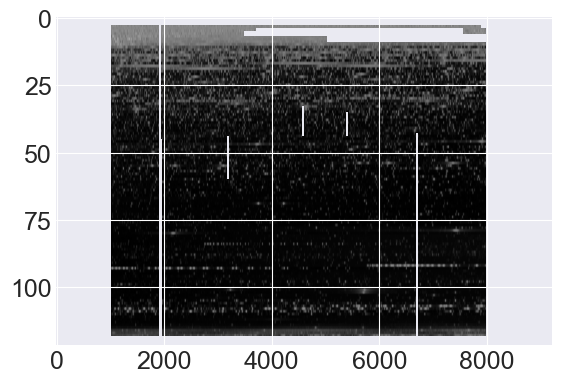

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.172398773133 5053.780644309584
window flux len is 53
maxes [ 3 19 47 50]
mins [11 32 48]
FWHM = 1.537912516600305
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.075582103605 8337.666553537672
window flux len is 43
maxes [1]
mins [26]
FWHM = 0.27546167742216815
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.319205674365 9605.91949470024
window flux len is 33
maxes [24]
mins [18 25]
winner is 9605.769545099527
FWHM = 0.41779264395095417
*** Index is 8, line is 868

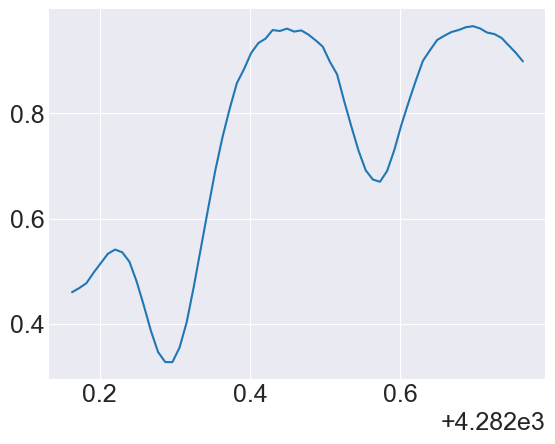

maxes [ 6 28 30 32 56]
mins [14 29 31 43]
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.1133108278555 4454.709976903736
window flux len is 69
maxes [ 2 30 32 34 36 66]
mins [15 31 33 35 51 67]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.63092126427 4514.226386424221
window flux len is 65
maxes [ 4  6  8 11 13 15 17 21 55]
mins [ 5  7  9 12 14 16 19 39]
winner is 4514.1428005515145
FWHM = 0.09433411810423395
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.15533059496 4618.761894749258
window flux len is 66
maxes [ 1  3  7 12 14 16 19 23 25 28 57 61]
mins [ 2  5  8 13 15 18 22 24 27 43 60 62]
winner is 4618.6873832360325
FWHM = 0.10022169001968838
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.372882920511 4657.965388711677
33
window flux 

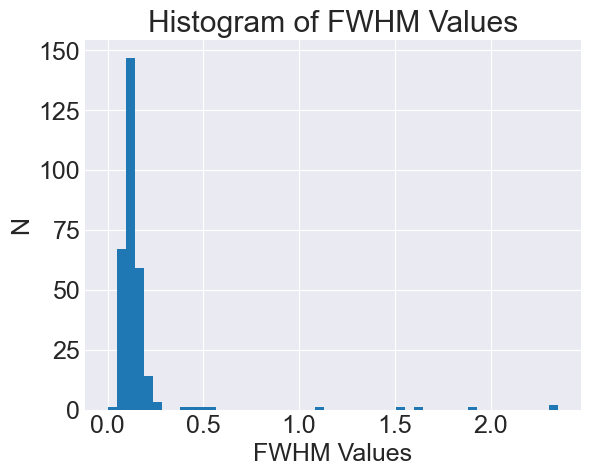

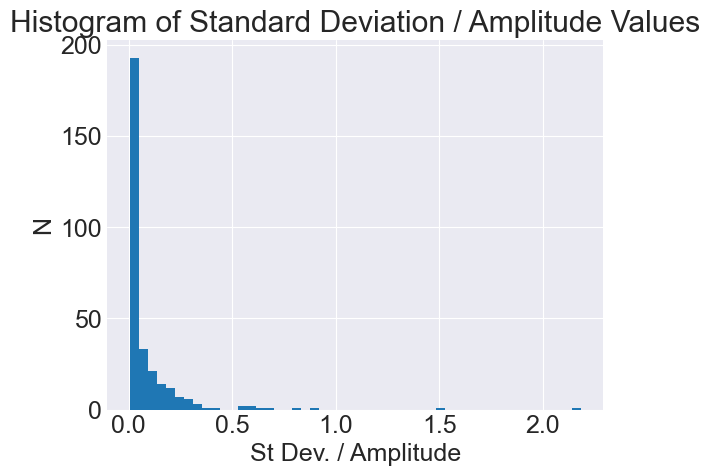

plotted lines 295 depths 295 fwhms 295
FINAL LENGTH OF DEPTH COUNTER IS 172
2460464.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


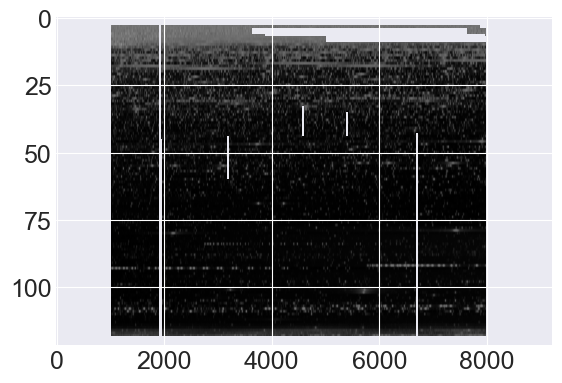

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.172590813899 5053.780836373466
window flux len is 53
maxes [ 3 20 49 51]
mins [11 32 50]
FWHM = 1.5303854418199658
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.07585863884 8337.666832344114
window flux len is 43
***** No maxima found, line 8337.372368849545 skipped *****
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.319581950433 9605.919869407044
window flux len is 33
maxes [1]
mins [19]
FWHM = 0.41932347475652
*** Index is 8, line is 8685.667297222295 ***
Di

/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dict_linelist['lambda (nm) '] = dict_linelist['lambda (nm) '].astype(float)


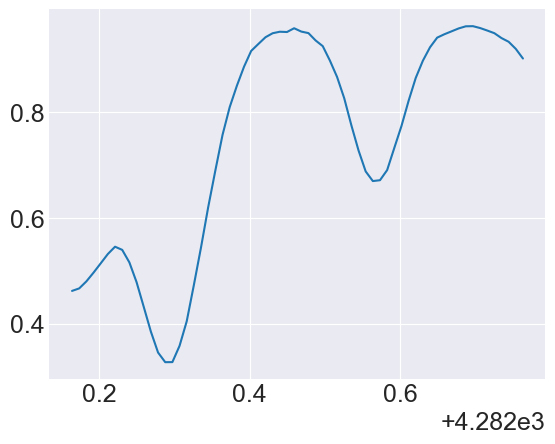

maxes [ 6 29 31 56]
mins [13 30 42]
FWHM = 0.17510382159366744
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.113480101979 4454.710146200534
window flux len is 69
maxes [ 2 31 33 35 67]
mins [15 32 34 51]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.631092800301 4514.226557982883
window flux len is 65
maxes [ 3  5  8 10 13 16 18 24 56]
mins [ 1  4  6  9 12 15 17 22 39]
FWHM = 0.0944100027853346
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.155506103337 4618.762070280687
window flux len is 66
maxes [ 1  3  7  9 11 14 17 20 22 25 57 59 62]
mins [ 2  5  8 10 12 16 19 21 24 43 58 61 64]
winner is 4618.687558764628
FWHM = 0.10033363360901781
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.373059919311 4657.965565732996
33
window flux len is 32

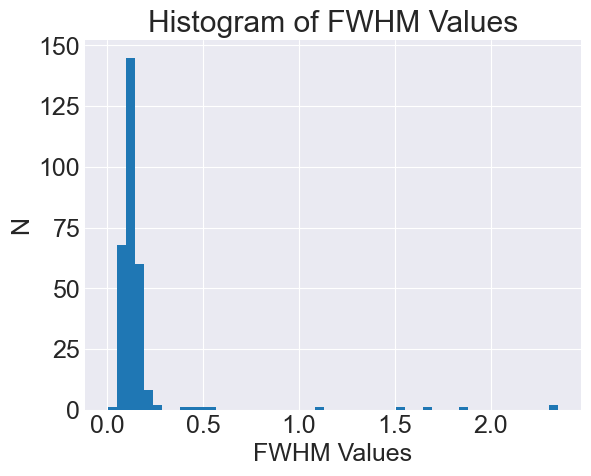

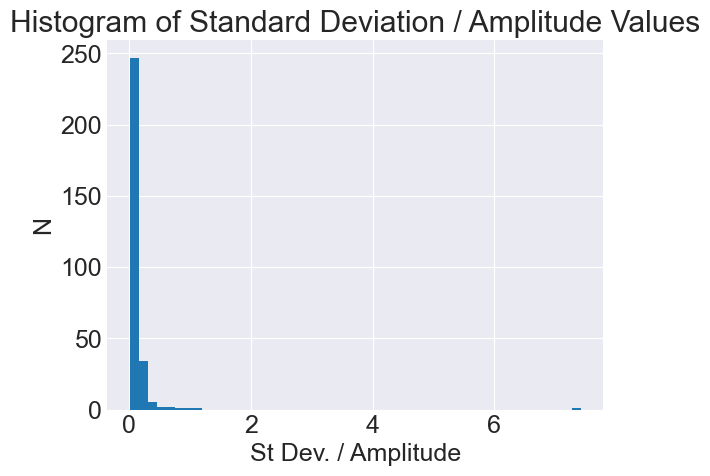

plotted lines 288 depths 288 fwhms 288
FINAL LENGTH OF DEPTH COUNTER IS 172
2460465.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


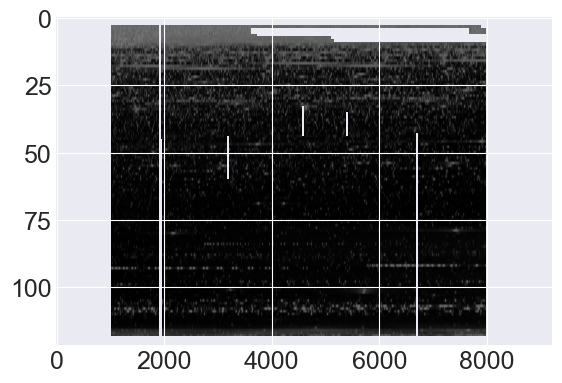

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.17257998034 5053.7808255386035
window flux len is 53
maxes [ 3 20 47]
mins [11 32]
FWHM = 0.09902787362363907
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.075923399027 8337.666896954941
window flux len is 43
maxes [41]
mins [25]
winner is 8337.65284868058
FWHM = 0.2767584937258026
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.319533917158 9605.919822778316
window flux len is 33
maxes [23]
mins [19 27]
winner is 9605.75112377846
FWHM = 0.49297727882387615
*** 

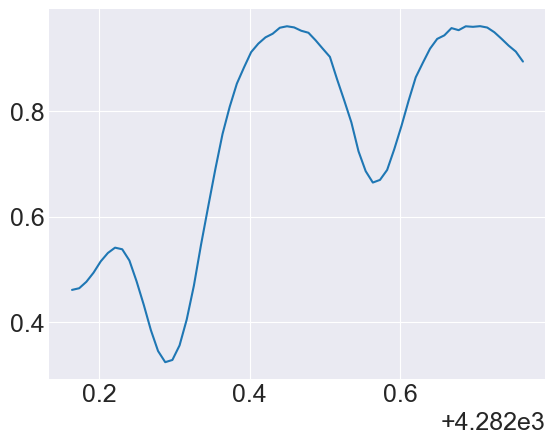

maxes [ 6 30 53 55 57]
mins [13 42 54 56]
winner is 4282.668377388343
FWHM = 0.17511613295516912
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.11347055275 4454.710136650027
window flux len is 69
maxes [ 2 30 34 65 67]
mins [15 32 51 66]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.631083123473 4514.226548304777
window flux len is 65
maxes [ 2  5  7  9 13 16 18 21 54 56]
mins [ 4  6  8 12 15 17 20 39 55]
winner is 4514.133672051022
FWHM = 0.09446085400970118
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.155496202417 4618.762060378467
window flux len is 66
maxes [ 1  4  6 10 13 16 21 26 28 58 63]
mins [ 2  5  7 12 15 20 24 27 43 60 64]
winner is 4618.696864989823
FWHM = 0.10033539709274321
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.37

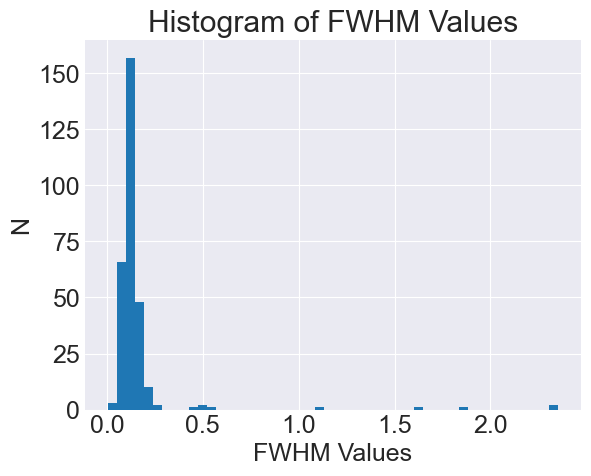

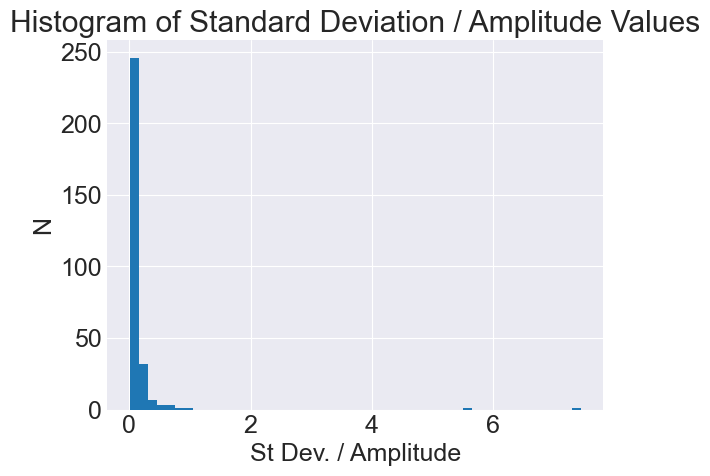

plotted lines 290 depths 290 fwhms 290
FINAL LENGTH OF DEPTH COUNTER IS 172
2460467.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


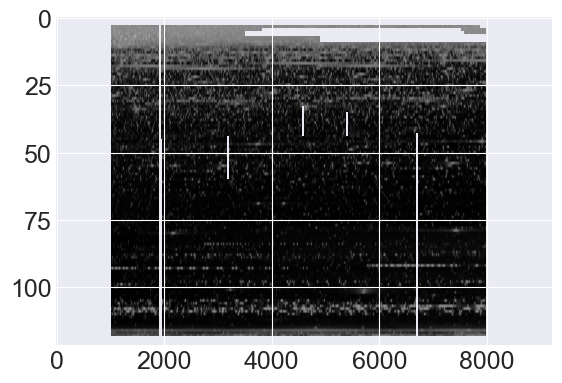

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.172861987941 5053.781107580149
window flux len is 53
maxes [ 3 20 46]
mins [11 32]
FWHM = 0.09790077279029566
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.07632572798 8337.667300357833
window flux len is 43
maxes [40]
mins [25]
winner is 8337.639202650726
FWHM = 0.29276661831203454
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.320095962123 9605.920383316574
window flux len is 33
maxes [22]
mins [20 27]
winner is 9605.732934057662
FWHM = 0.5511327317757594
***

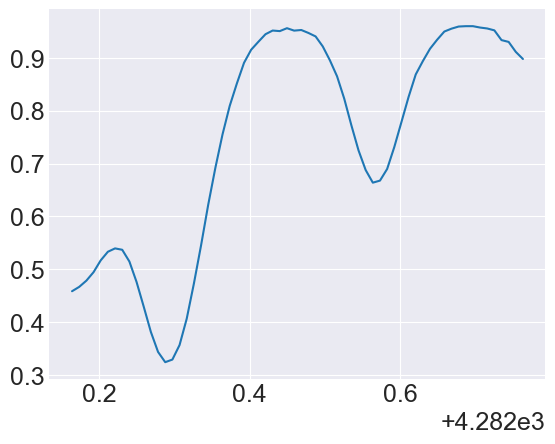

maxes [ 6 28 30 32 56]
mins [13 29 31 42]
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.113719128044 4454.71038525862
window flux len is 69
maxes [ 3 30 34 36 66]
mins [15 32 35 51]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.631335020326 4514.226800234864
window flux len is 65
maxes [ 1  6  9 14 18 22 25 55]
mins [ 2  8 13 17 21 24 39]
FWHM = 0.09432106721155964
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.155753932572 4618.762318142473
window flux len is 66
maxes [ 4  6  9 14 16 19 25 58 60 62 64]
mins [ 3  5  8 13 15 18 24 43 59 61 63]
winner is 4618.697122750191
FWHM = 0.10005957100488534
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.373309853122 4657.9658156986025
33
window flux len is 32
*** Index is 88, line is 4743.8929606311

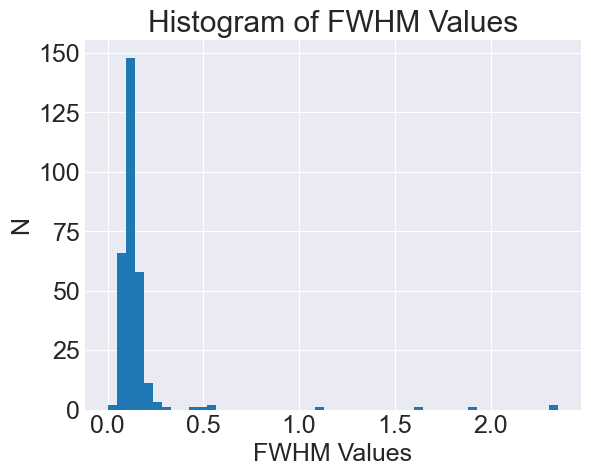

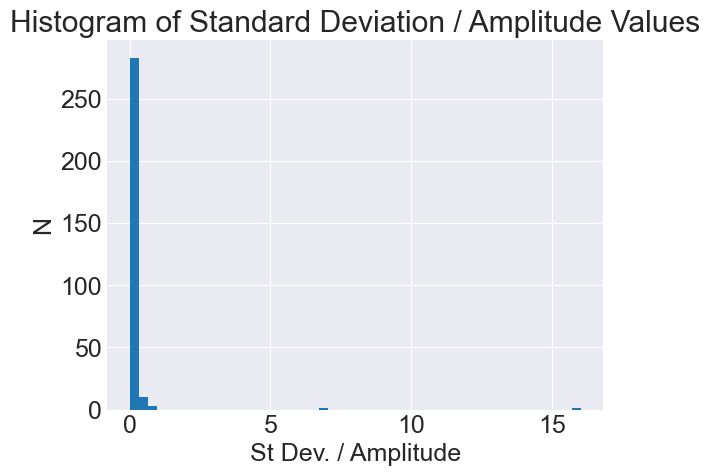

plotted lines 293 depths 293 fwhms 293
FINAL LENGTH OF DEPTH COUNTER IS 172
2460468.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


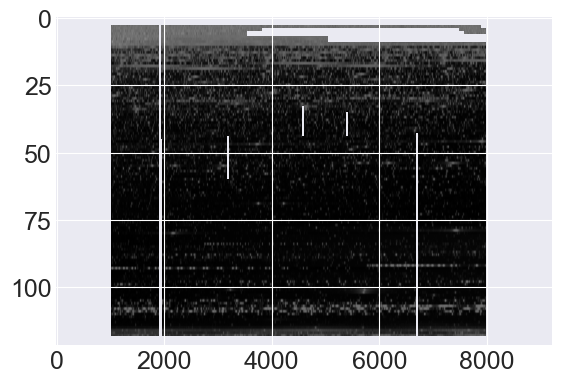

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.172991819786 5053.781237427622
window flux len is 53
maxes [ 3 20 47]
mins [11 32 51]
FWHM = 0.09809051944188535
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.076530398159 8337.667499912279
window flux len is 43
maxes [39]
mins [25]
winner is 8337.625352075567
FWHM = 0.3026767433280966
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.320307773274 9605.920597506381
window flux len is 33
maxes [21]
mins [20 27]
winner is 9605.714395468929
FWHM = 0.5547254226835877


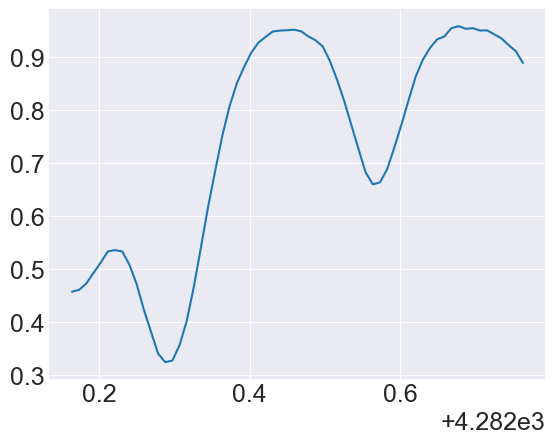

maxes [ 6 31 54 56 58]
mins [13 42 55 57]
FWHM = 0.17477270328407093
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.113833568183 4454.710499714089
window flux len is 69
maxes [ 1  3 30 33 37 65]
mins [ 2 15 31 36 51 67]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.631450989659 4514.226916219494
window flux len is 65
maxes [ 2  7 12 15 18 20 24 54 56]
mins [ 3  9 14 16 19 23 39 55]
winner is 4514.1340399581695
FWHM = 0.09454789205591273
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.155872587465 4618.762436812949
window flux len is 66
maxes [ 1  5  8 15 19 23 26 58 60]
mins [ 3  6 13 18 21 25 43 59 64]
winner is 4618.697241418991
FWHM = 0.10004973647293171
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.373429515636 4657.965935376341
33
win

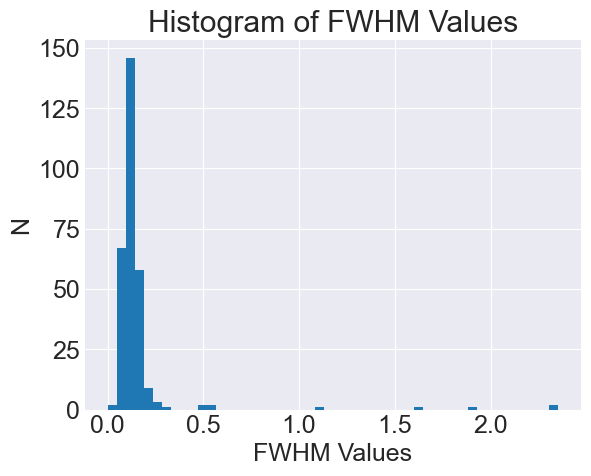

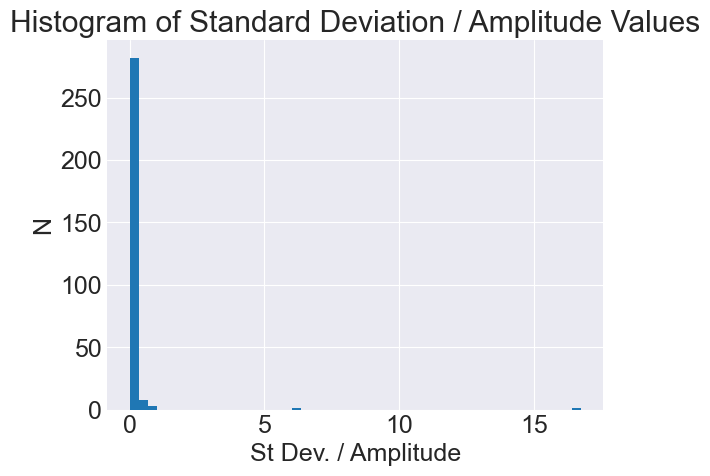

plotted lines 290 depths 290 fwhms 290
FINAL LENGTH OF DEPTH COUNTER IS 172
2460474.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


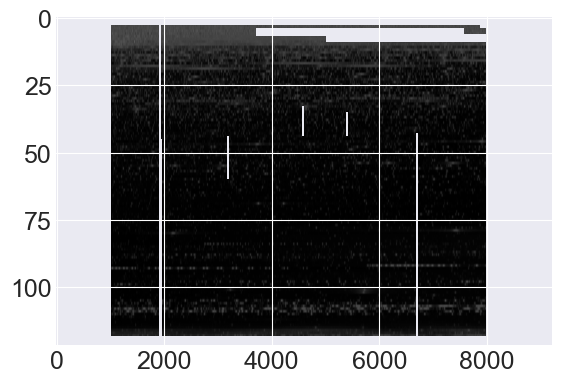

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.174087412007 5053.782333151719
window flux len is 53
maxes [ 2 20 46]
mins [11 31 51]
FWHM = 0.09912974931363516
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.078311393081 8337.669281283366
window flux len is 43
maxes [40]
mins [25]
winner is 8337.641183804153
FWHM = 0.29392661418248384
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.32240293064 9605.922689292127
window flux len is 33
maxes [21]
mins [19 27]
winner is 9605.716488422491
FWHM = 0.563488642521854
*

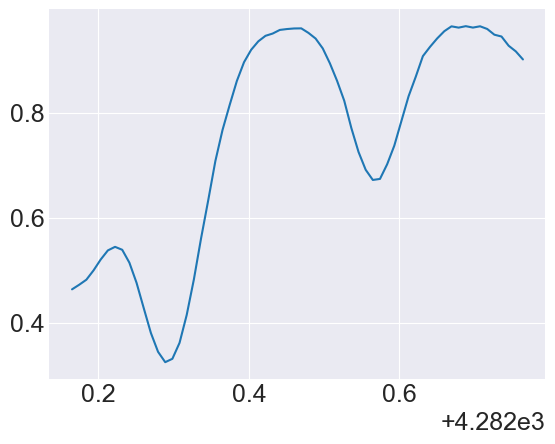

maxes [ 6 32 53 55 57]
mins [13 42 54 56]
FWHM = 0.17313584494795736
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.114799276753 4454.711465552024
window flux len is 69
maxes [ 2 30 34 66]
mins [15 31 51]
winner is 4454.69395622633
FWHM = 1.984347903666627
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.632429602407 4514.2278949613465
window flux len is 65
maxes [ 3  6  8 10 12 14 17 19 21 24 26 54]
mins [ 4  7  9 11 13 15 18 20 23 25 39]
FWHM = 0.09427480567043939
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.156873862437 4618.7541264649035
window flux len is 65
maxes [ 2  4  8 10 14 16 18 20 23 26 59 62]
mins [ 1  3  7  9 13 15 17 19 22 25 43 60]
winner is 4618.70755831629
FWHM = 0.10019059824207688
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds a

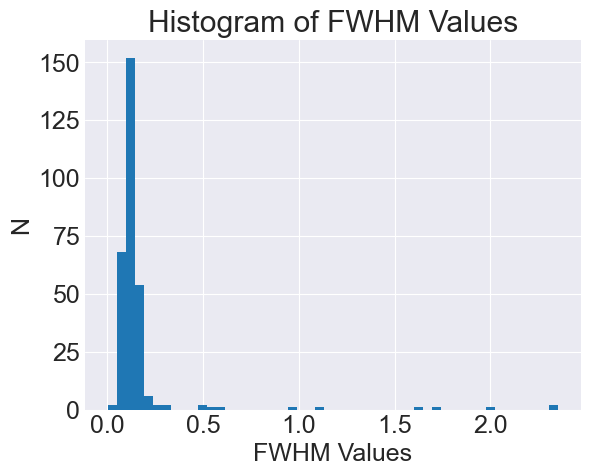

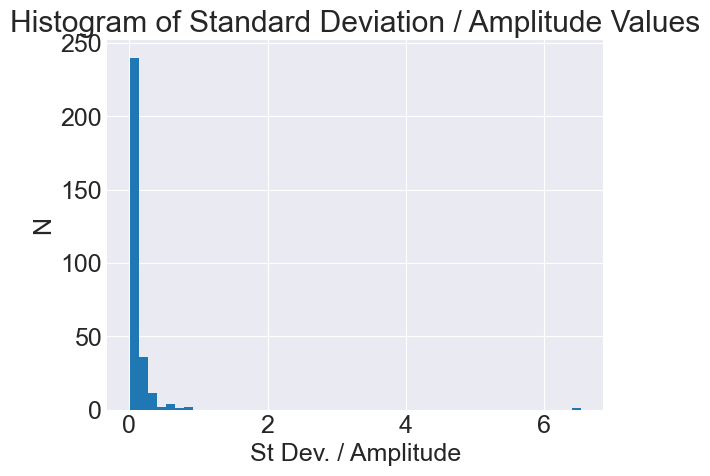

plotted lines 291 depths 291 fwhms 291
FINAL LENGTH OF DEPTH COUNTER IS 172
2460475.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


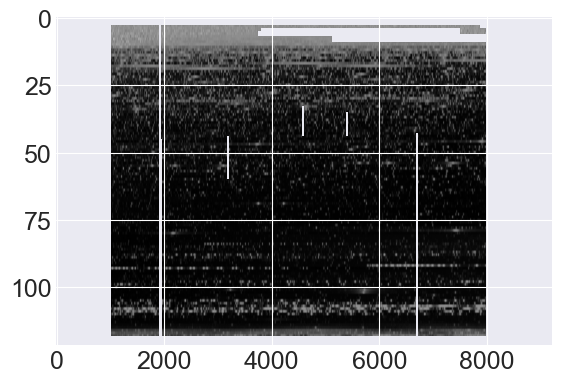

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.17418681012 5053.782432561796
window flux len is 53
maxes [ 3 20 46]
mins [11 32 51]
FWHM = 0.09716011224725572
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.078531924042 8337.669509047348
window flux len is 43
maxes [39]
mins [25]
winner is 8337.627360660508
FWHM = 0.3176338265679717
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.322551069487 9605.922838033586
window flux len is 33
***** No maxima found, line 9605.618031381042 skipped *****
*** Index is 8, lin

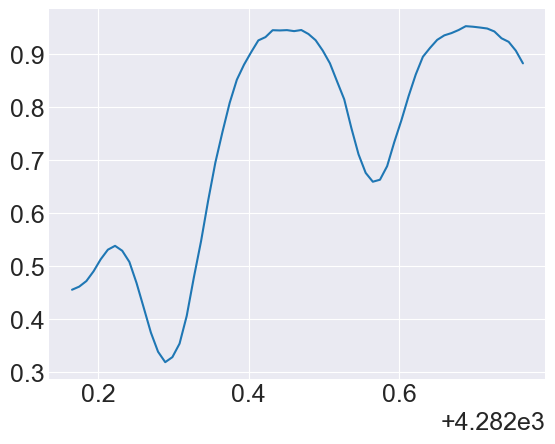

maxes [ 6 28 30 32 55]
mins [13 29 31 42]
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.1148868911105 4454.711553178118
window flux len is 69
maxes [ 2 30 33 65]
mins [15 31 50]
winner is 4454.685288287293
FWHM = 2.032689999395531
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.6325183875015 4514.227983758155
window flux len is 65
maxes [ 4  9 11 13 17 19 24 54]
mins [ 6 10 12 15 18 22 39]
winner is 4514.135107474866
FWHM = 0.09402734917592234
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.156964703574 4618.75421731779
window flux len is 65
maxes [ 2  9 11 13 16 18 21 24 27 56 58 60 63]
mins [ 1  5 10 12 15 17 20 23 26 43 57 59 62]
winner is 4618.679700777603
FWHM = 0.10044325051840189
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.36539472

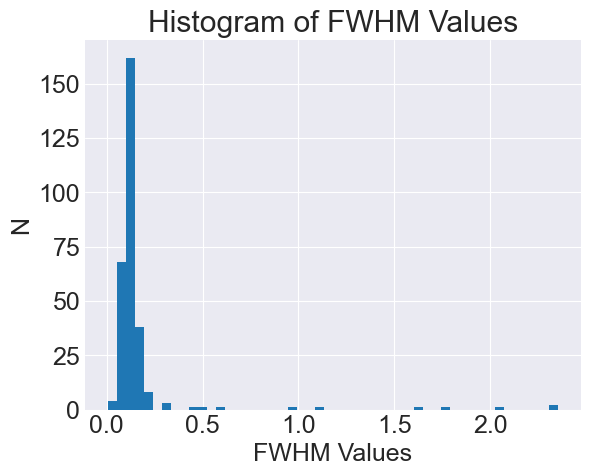

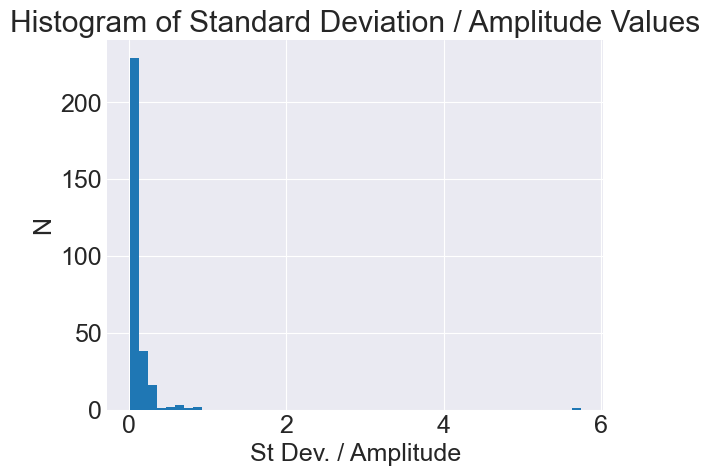

plotted lines 287 depths 287 fwhms 287
FINAL LENGTH OF DEPTH COUNTER IS 172
2460476.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


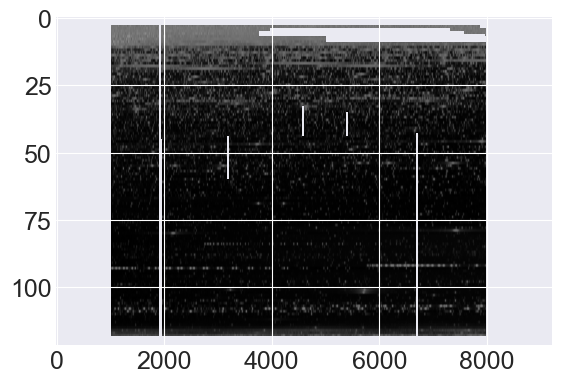

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.174333379114 5053.782579148434
window flux len is 53
maxes [ 3 19 48 51]
mins [11 32 50]
FWHM = 0.10046966554814465
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.078762017733 8337.66973441433
window flux len is 43
***** No maxima found, line 8337.372368849545 skipped *****
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.322840851544 9605.923130010544
window flux len is 33
***** No maxima found, line 9605.618031381042 skipped *****
*** Index is 8, line is 8685.66

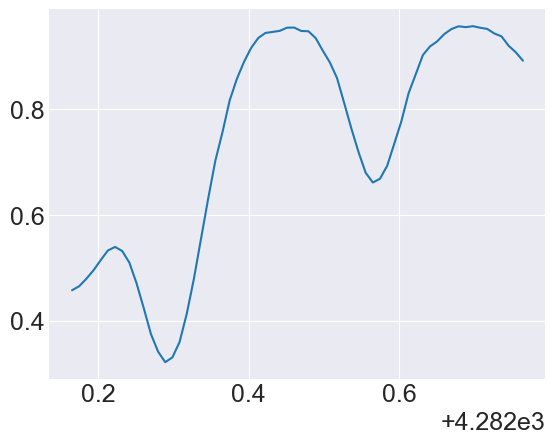

maxes [ 6 31 54 56]
mins [13 42 55]
FWHM = 0.17275635243309356
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.115016084192 4454.711682388505
window flux len is 69
maxes [ 1 29 32 35 65]
mins [15 30 34 50]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.632649306911 4514.228114694836
window flux len is 65
maxes [ 1  3  6 11 13 16 19 21 24 54]
mins [ 2  4 10 12 14 18 20 22 39]
winner is 4514.135238408854
FWHM = 0.09416035137166397
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.1570986547495 4618.754351286289
window flux len is 65
maxes [ 3  8 12 15 18 20 28 58 60]
mins [ 2  4 11 14 17 19 27 43 59]
winner is 4618.698467630004
FWHM = 0.10075012947672664
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.365529816367 4657.967172012739
34
window flux 

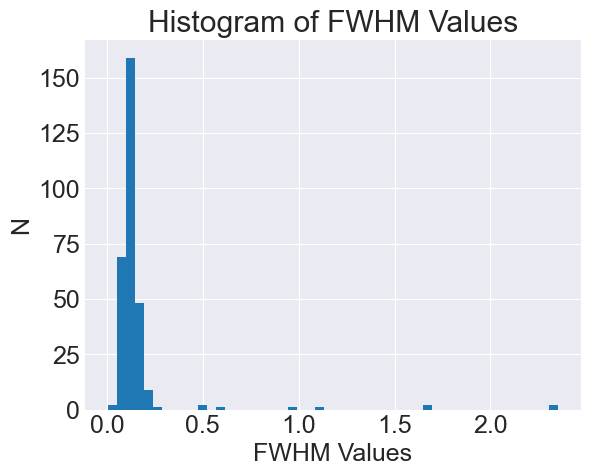

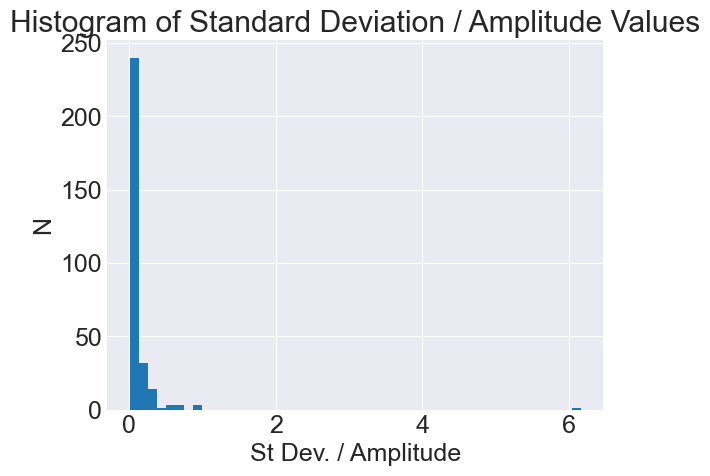

plotted lines 292 depths 292 fwhms 292
FINAL LENGTH OF DEPTH COUNTER IS 172
2460477.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


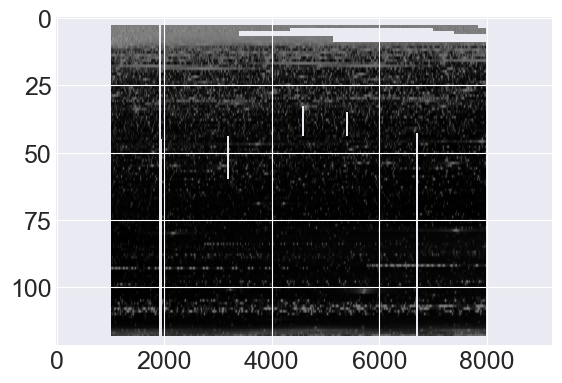

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.174386321818 5053.782632097509
window flux len is 53
maxes [ 4 20 47 51]
mins [11 32 50]
FWHM = 0.09862747694146286
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.078813980426 8337.66978084671
window flux len is 43
maxes [ 1 41]
mins [25]
winner is 8337.65573272809
FWHM = 0.2847001485030302
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.322932824372 9605.923220150627
window flux len is 33
maxes [ 1 22]
mins [19 27]
winner is 9605.735770880676
FWHM = 0.5349878025

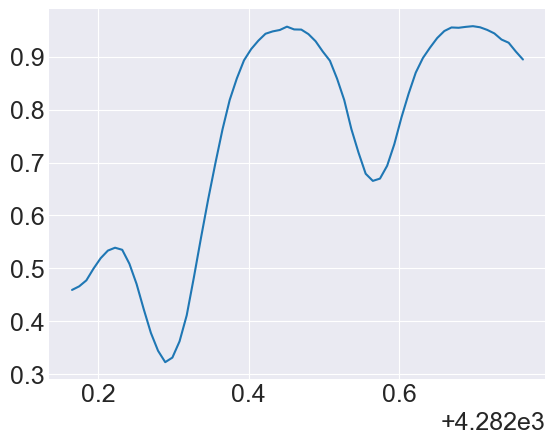

maxes [ 6 30 53 56]
mins [13 42 54]
winner is 4282.669908300142
FWHM = 0.17279081424439988
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.115062750479 4454.711729061045
window flux len is 69
maxes [ 1 29 32 64 66]
mins [15 30 50 65]
winner is 4454.676708002866
FWHM = 1.9542818275649303
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.632696596773 4514.228161990937
window flux len is 65
maxes [ 3  5  8 10 15 20 22 54]
mins [ 4  7  9 13 19 21 39]
winner is 4514.13528570398
FWHM = 0.09406578037008428
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.157147039727 4618.754399677522
window flux len is 65
maxes [ 5  7 10 13 16 21 24 27 59]
mins [ 3  6  8 12 14 20 23 26 43]
winner is 4618.707831526152
FWHM = 0.1004010337686907
*** Index is 87, line is 4657.6694603148835 ***
wavele

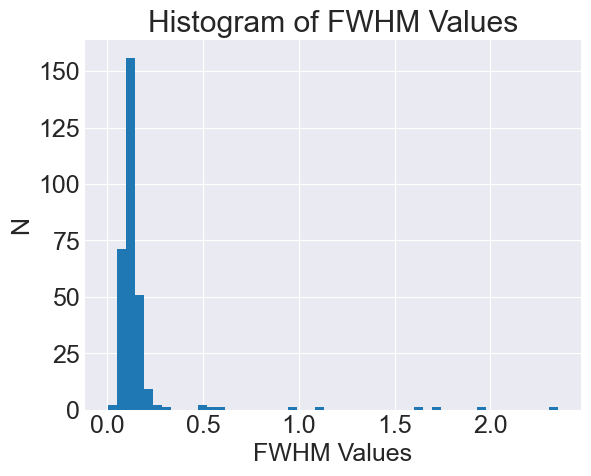

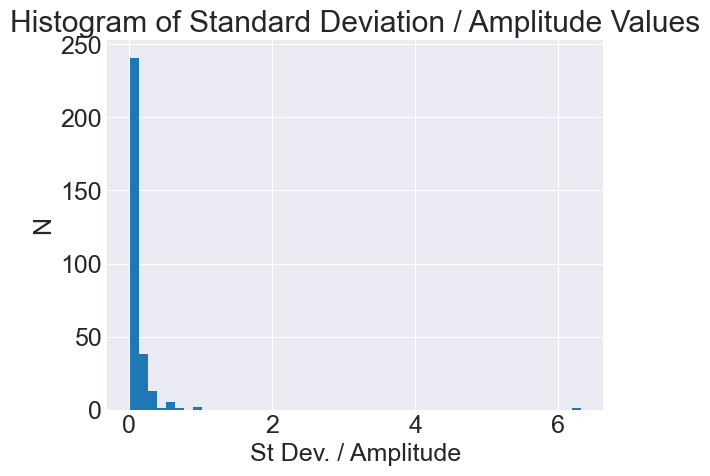

plotted lines 297 depths 297 fwhms 297
FINAL LENGTH OF DEPTH COUNTER IS 172
2460478.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


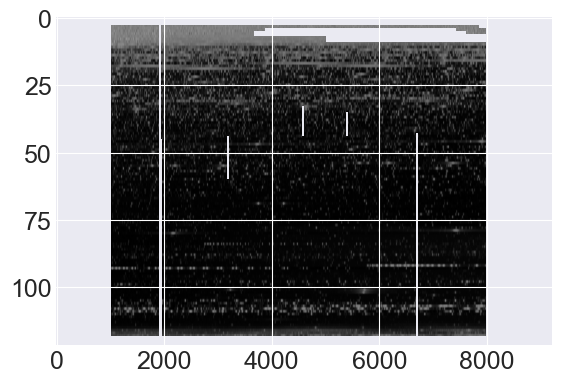

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.174572097713 5053.782817895766
window flux len is 53
maxes [ 3 19 46 48]
mins [11 32 47 51]
FWHM = 0.0991077621087817
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.079159321496 8337.670130182742
window flux len is 43
maxes [41]
mins [25]
winner is 8337.656081971707
FWHM = 0.27715922536084464
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.323331360549 9605.923616043887
window flux len is 33
maxes [23]
mins [18 27]
winner is 9605.754918207862
FWHM = 0.53567071680

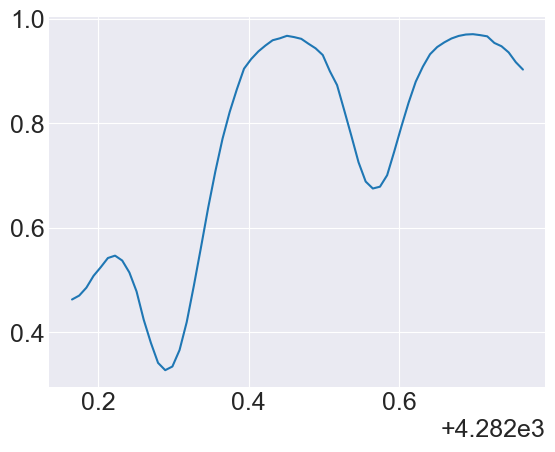

maxes [ 6 30 56]
mins [13 42]
FWHM = 0.17287187248173197
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.11522650244 4454.711892834943
window flux len is 69
maxes [ 2 30 32 34 36 65]
mins [15 31 33 35 50]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.632862536852 4514.228327952907
window flux len is 65
maxes [ 3  6 12 15 18 22 24 55]
mins [ 4 11 14 17 20 23 39]
FWHM = 0.09422445534989085
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.157316822561 4618.754569482316
window flux len is 65
maxes [ 1  4  7 10 14 18 20 58 63]
mins [ 2  5  8 12 15 19 43 61]
winner is 4618.698685823391
FWHM = 0.10029069068991946
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.365749836437 4657.967392061232
34
window flux len is 32
*** Index is 88, line is 4743.89296

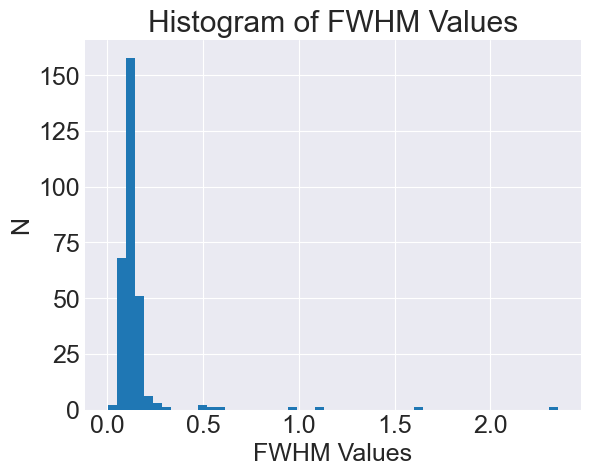

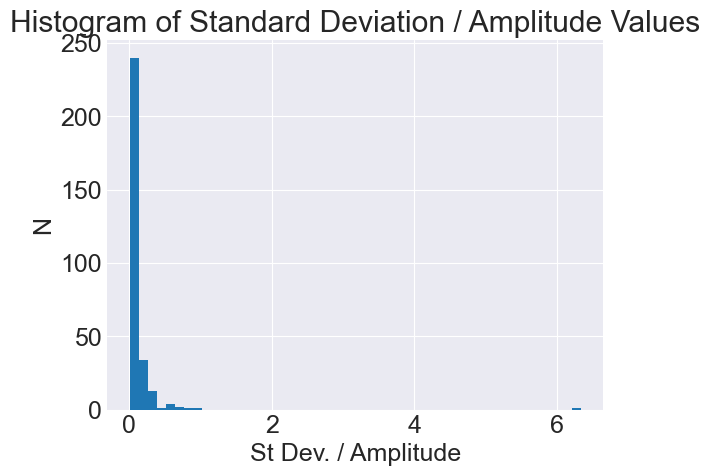

plotted lines 294 depths 294 fwhms 294
FINAL LENGTH OF DEPTH COUNTER IS 172
2460479.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


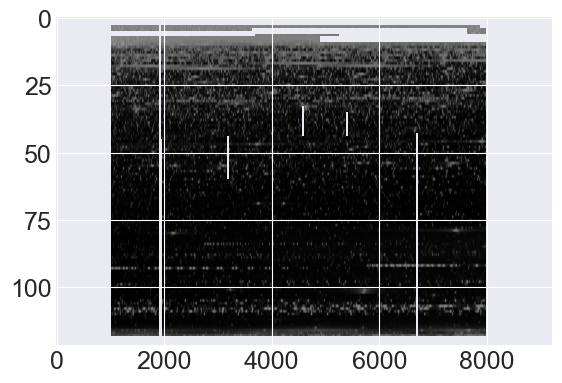

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.174722447239 5053.78296826339
window flux len is 53
maxes [ 3 19 49]
mins [11 31]
FWHM = 0.09906669172634545
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.079403501688 8337.670375282809
window flux len is 43
maxes [41]
mins [25]
winner is 8337.656327048177
FWHM = 0.279976303115174
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.323576470393 9605.923864014228
window flux len is 33
maxes [ 3 23]
mins [ 2 19 27]
winner is 9605.755165371864
FWHM = 0.4862299063388970

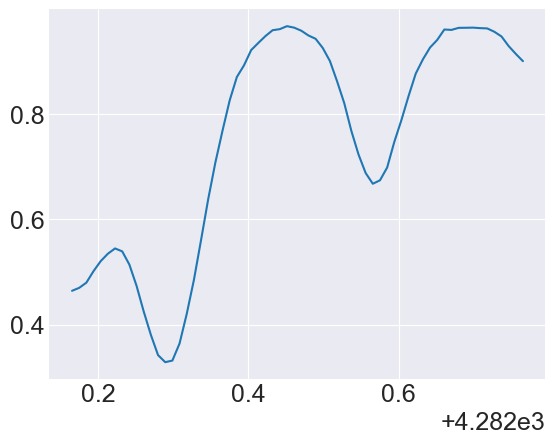

maxes [ 6 30 52 56]
mins [13 42 53]
winner is 4282.6606827377755
FWHM = 0.17290035594176748
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.115359027866 4454.71202537812
window flux len is 69
maxes [ 1  3 30 32 35 65]
mins [ 2 14 31 34 51]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.632996833136 4514.2284622669085
window flux len is 65
maxes [ 3  6  8 10 14 19 21 55]
mins [ 4  7  9 13 18 20 39]
winner is 4514.144876355765
FWHM = 0.09433432719748151
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.157454228812 4618.754706906335
window flux len is 65
maxes [ 1  3  6  9 14 20 22 25 27 58 61]
mins [ 2  4  8 10 19 21 23 26 43 60 63]
winner is 4618.698823245749
FWHM = 0.10029430451976219
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.365888409274

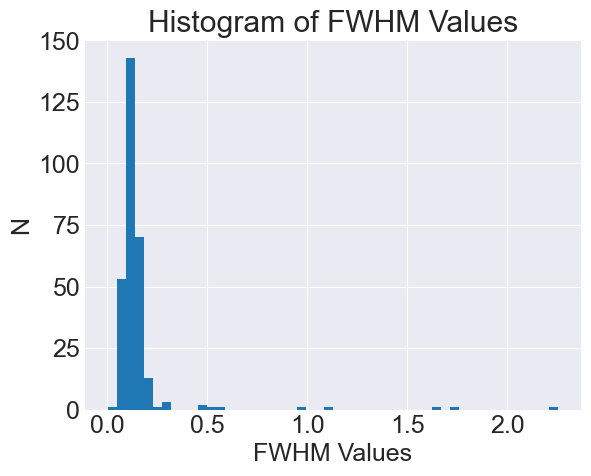

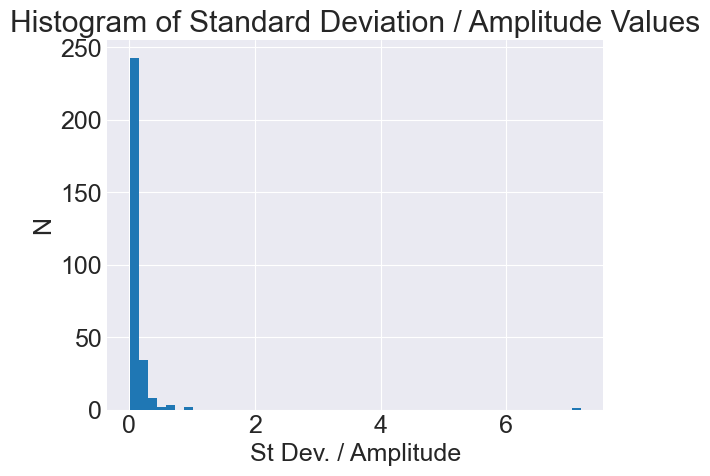

plotted lines 289 depths 289 fwhms 289
FINAL LENGTH OF DEPTH COUNTER IS 172
2460480.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


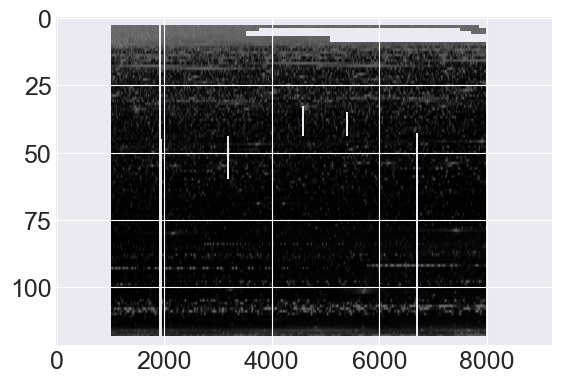

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.174715341746 5053.7829611570405
window flux len is 53
maxes [ 3 19 46]
mins [11 32 51]
FWHM = 0.09815776580698879
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.079350712362 8337.670321838625
window flux len is 43
maxes [40]
mins [25]
winner is 8337.642224299934
FWHM = 0.2913612818783897
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.323615815612 9605.923899895366
window flux len is 33
maxes [ 1 23]
mins [20 27]
winner is 9605.755202240141
FWHM = 0.5700230997811

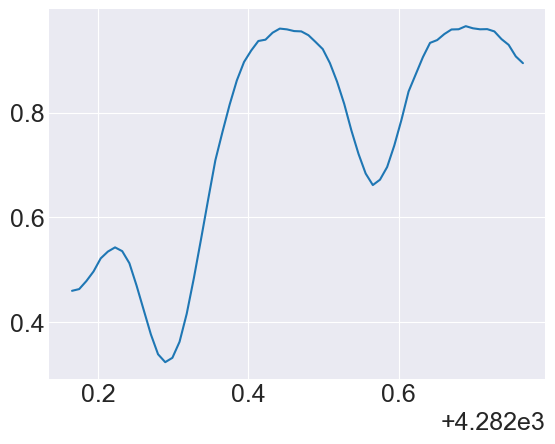

maxes [ 6 29 55 58]
mins [13 42 57]
winner is 4282.689206258684
FWHM = 0.17325993819814953
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.115352764737 4454.712019114151
window flux len is 69
maxes [ 3 31 34 37 65]
mins [ 1 15 33 36 50]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.632990486315 4514.22845591925
window flux len is 65
maxes [ 4  6 11 15 17 23 25 54]
mins [ 5 10 13 16 22 24 39]
FWHM = 0.09406496007587381
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.157447735015 4618.7547004117
window flux len is 65
maxes [ 4  6  8 10 13 15 17 21 25 59 62]
mins [ 1  5  7  9 11 14 16 19 24 43 61]
winner is 4618.708132257297
FWHM = 0.10081938623146525
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.365881860344 4657.967524102194
34
window flux l

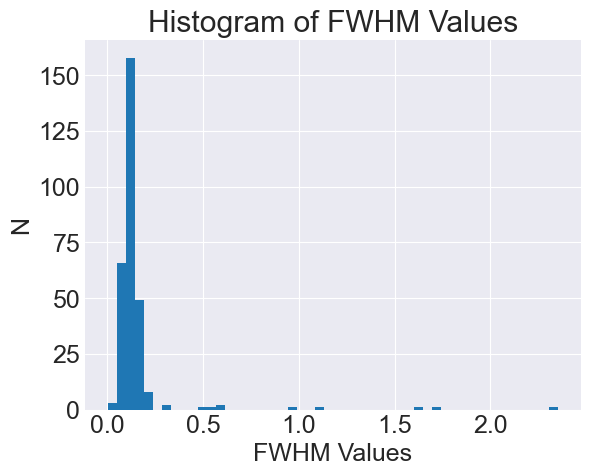

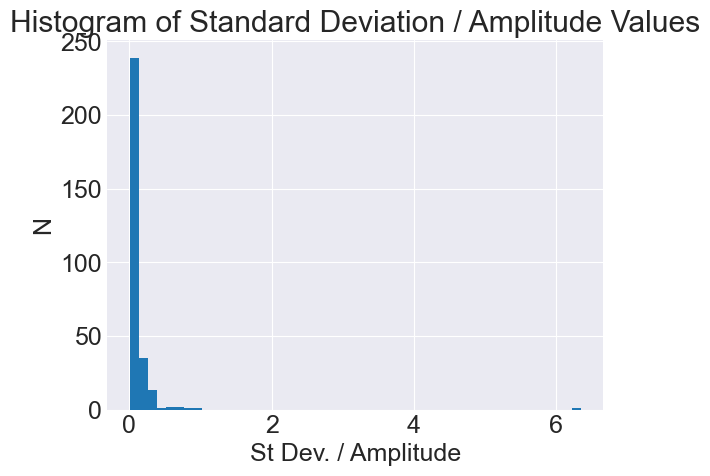

plotted lines 291 depths 291 fwhms 291
FINAL LENGTH OF DEPTH COUNTER IS 172
2460481.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


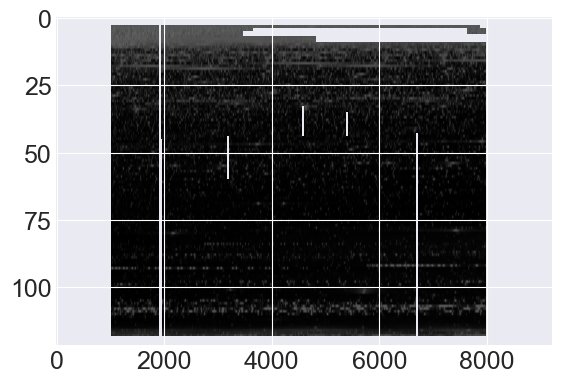

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.17475109575 5053.78299691535
window flux len is 53
maxes [ 3 20 46]
mins [10 32 51]
FWHM = 0.09879697360161652
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.079410323611 8337.67037872658
window flux len is 43
maxes [40]
mins [25]
winner is 8337.642281316375
FWHM = 0.29917718522351416
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.323624508283 9605.92391275961
window flux len is 33
maxes [20 22]
mins [19 21 27]
winner is 9605.698957968238
FWHM = 0.57658231260678

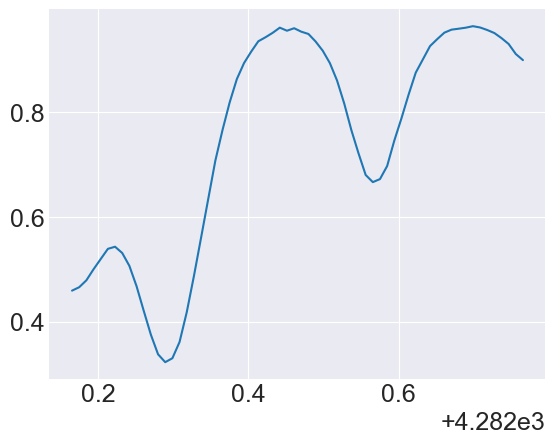

maxes [ 6 29 31 56]
mins [13 30 42]
FWHM = 0.1725101301137013
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.115384280066 4454.712050633702
window flux len is 69
maxes [ 2 31 35 66]
mins [15 33 50]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.633022422763 4514.228487859912
window flux len is 65
maxes [ 3  5  7 10 13 15 17 20 22 54 56]
mins [ 4  6  9 12 14 16 19 21 39 55]
winner is 4514.135611566252
FWHM = 0.09402401880936684
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.157480411031 4618.754733091942
window flux len is 65
maxes [ 2  8 11 13 15 17 19 24 28 59 61]
mins [ 5  9 12 14 16 18 21 27 43 60]
FWHM = 0.10063475199608743
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.365914813782 4657.967557059889
34
window flux len is 32
*** Index i

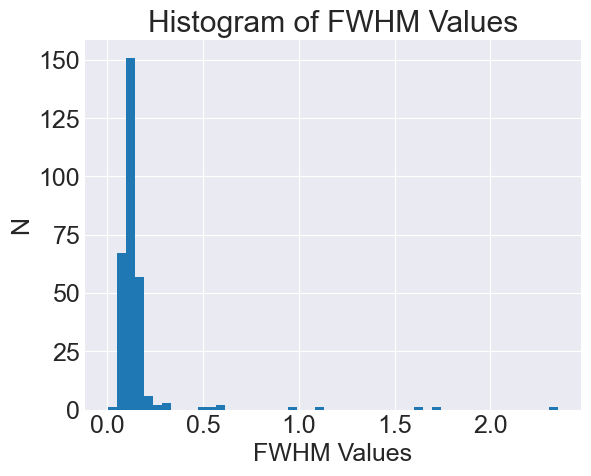

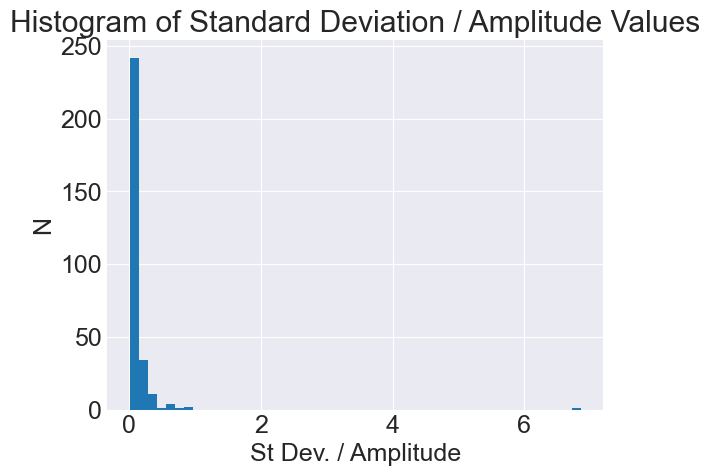

plotted lines 292 depths 292 fwhms 292
FINAL LENGTH OF DEPTH COUNTER IS 172
2460482.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


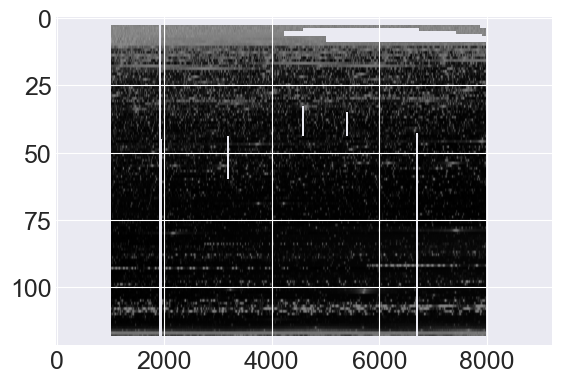

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.174771507758 5053.783017329813
window flux len is 53
maxes [ 3 20 46 48]
mins [11 32 47 51]
FWHM = 0.09761678235180349
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.065355168064 8337.67042274383
window flux len is 44
maxes [ 3 41]
mins [ 2 26]
winner is 8337.642325111814
FWHM = 0.30229058807141457
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.323726346454 9605.92401235019
window flux len is 33
maxes [22]
mins [21 27]
winner is 9605.736563527194
FWHM = 0.576586

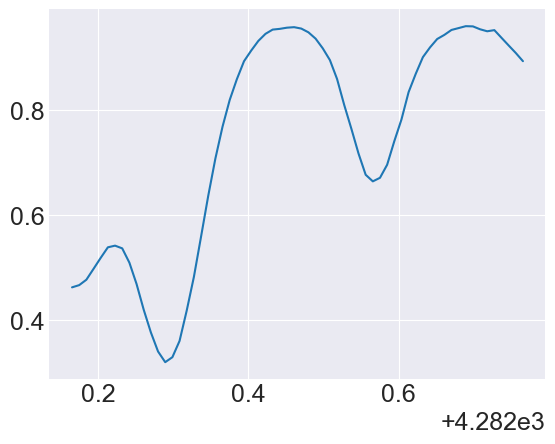

maxes [ 6 31 55 59]
mins [13 42 58]
FWHM = 0.17190986579507084
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.115402272208 4454.712068628254
window flux len is 69
maxes [ 2 30 32 36 66]
mins [15 31 35 50]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.633040655323 4514.228506094877
window flux len is 65
maxes [ 3  5 12 15 20 55 57]
mins [ 4 10 14 18 39 56]
winner is 4514.144920182922
FWHM = 0.09453045310877005
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.157499065812 4618.754751749135
window flux len is 65
maxes [ 3  5  8 11 15 18 24 28 60 62]
mins [ 2  4  6 10 13 17 23 26 43 61 63]
FWHM = 0.10044301987514338
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.365933626942 4657.96757587548
34
window flux len is 32
*** Index is 88, line is 4743

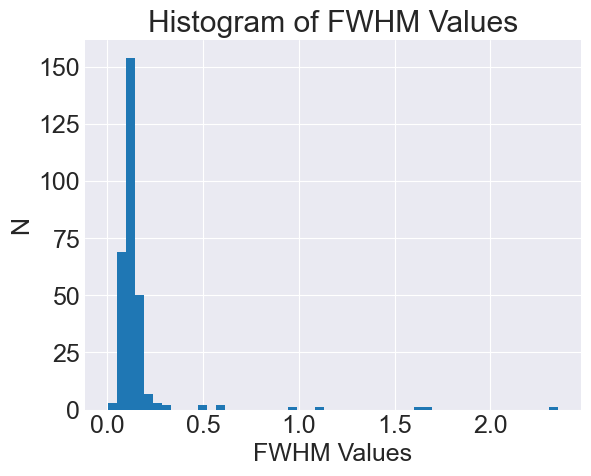

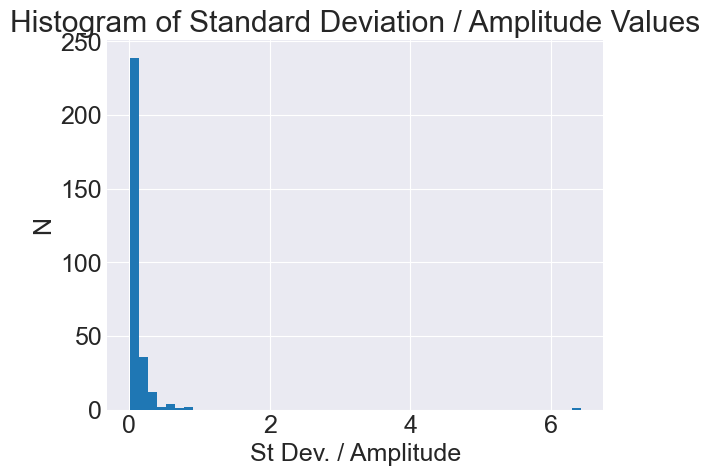

plotted lines 293 depths 293 fwhms 293
FINAL LENGTH OF DEPTH COUNTER IS 172
2460483.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


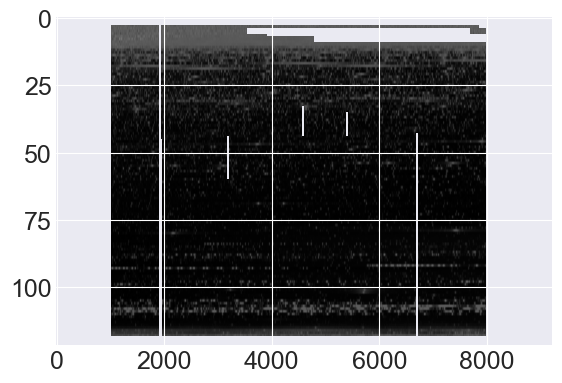

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.174808360776 5053.783054187268
window flux len is 53
maxes [ 3 20 46]
mins [11 32 51]
FWHM = 0.09757702992643937
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.065414136752 8337.670479309605
window flux len is 44
maxes [ 4 39]
mins [ 2 26]
winner is 8337.614279870155
FWHM = 0.3341120971424594
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.323772806953 9605.92405958211
window flux len is 33
maxes [20]
mins [19 28]
winner is 9605.699105350133
FWHM = 0.575598946663

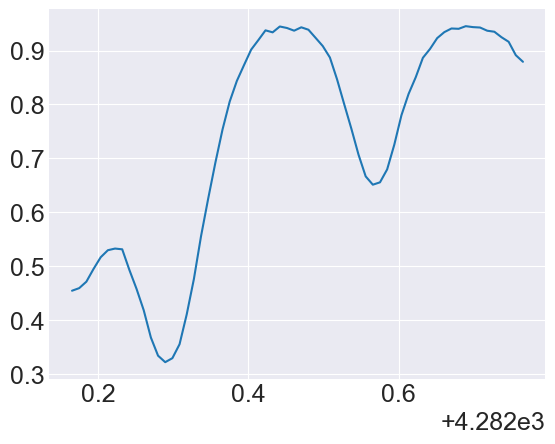

maxes [ 6 27 29 32 53 55]
mins [13 28 31 42 54]
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.11543475626 4454.712101116658
window flux len is 69
maxes [ 2 30 32 36 64 67]
mins [15 31 35 50 66]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.633073573441 4514.228539017338
window flux len is 65
maxes [ 4  8 11 15 17 20 22 24 53 56]
mins [ 6  9 13 16 18 21 23 39 54]
winner is 4514.126371728755
FWHM = 0.0945606481536138
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.157532746231 4618.75478543391
window flux len is 65
maxes [ 1  3  9 14 17 21 27 58 62]
mins [ 2  7 11 15 20 26 43 61]
winner is 4618.698901772373
FWHM = 0.10050226832100793
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.36596759331 4657.967609846235
34
window flux len is 32
*** Ind

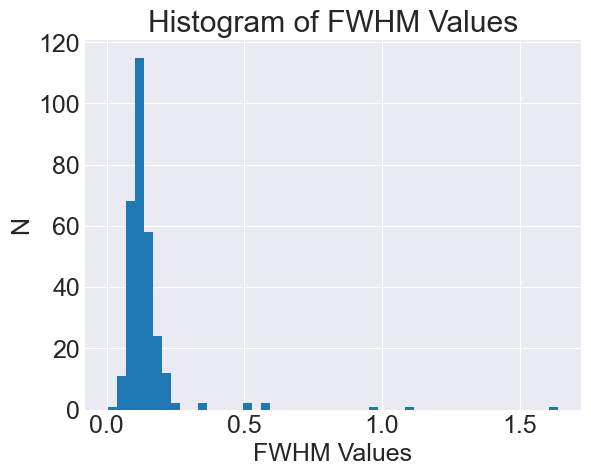

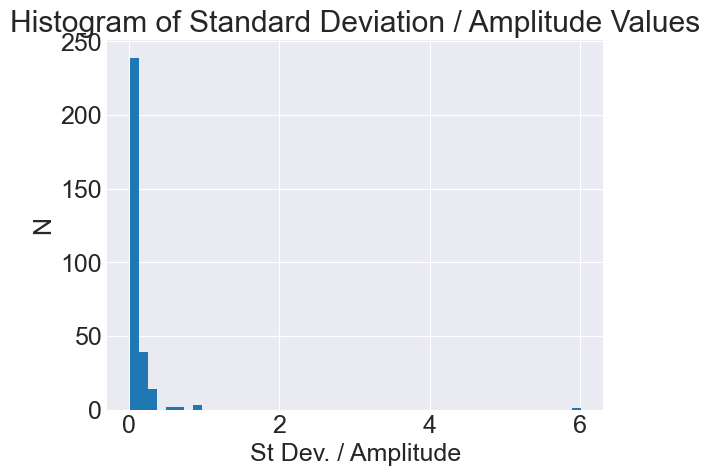

plotted lines 298 depths 298 fwhms 298
FINAL LENGTH OF DEPTH COUNTER IS 172
2460486.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


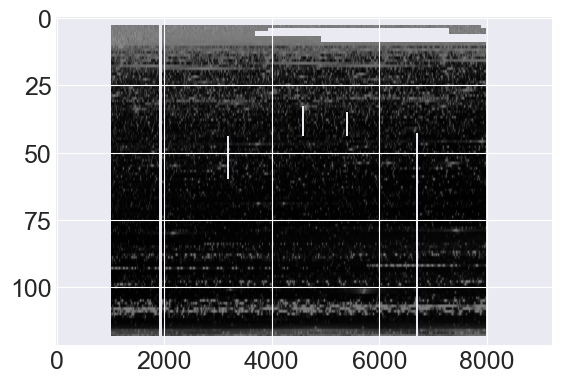

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.173661294665 5053.781906983087
window flux len is 53
maxes [ 4 20 46]
mins [11 32 51]
FWHM = 0.0954226115868243
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.077622099048 8337.668592334438
window flux len is 43
maxes [ 3 37]
mins [ 2 26]
winner is 8337.598340359433
FWHM = 0.42139973963633687
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.32159275365 9605.92188096152
window flux len is 33
***** No maxima found, line 9605.618031381042 skipped *****
*** Index is 8

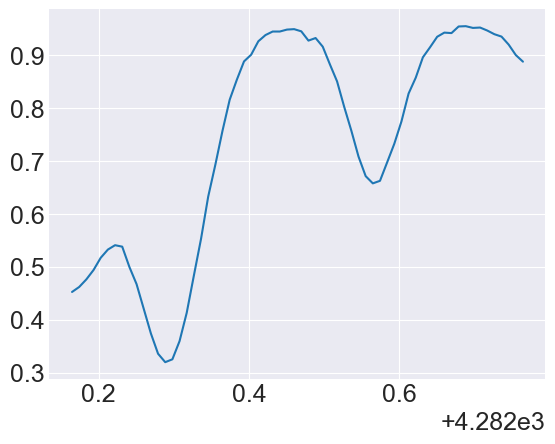

maxes [ 6 31 34 52 55 57]
mins [13 33 42 53 56]
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.114423676086 4454.71108990104
window flux len is 69
maxes [ 1 29 33 35 65]
mins [15 31 34 50]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.632048982816 4514.227514291543
window flux len is 65
maxes [ 3  6 11 17 22 25 54 56]
mins [ 5 10 15 20 24 39 55]
FWHM = 0.09447687341586367
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.156484428649 4618.763048734495
window flux len is 66
maxes [ 1  4  6  9 11 14 17 19 21 24 26 59]
mins [ 2  5  8 10 13 16 18 20 23 25 43 64]
winner is 4618.707168836062
FWHM = 0.10016745095861357
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.364910375449 4657.966552491802
34
window flux len is 32
*** Index is 88, line is 4743

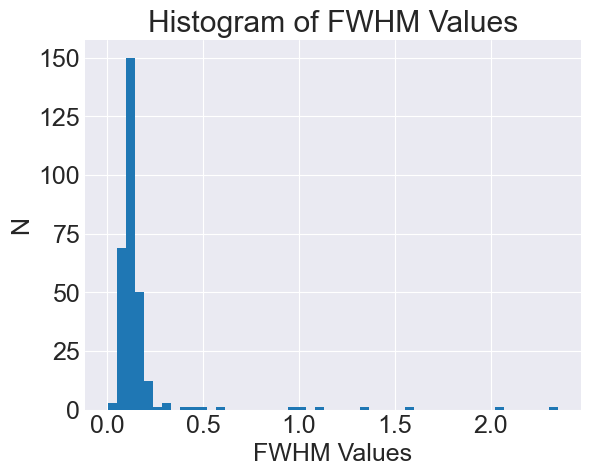

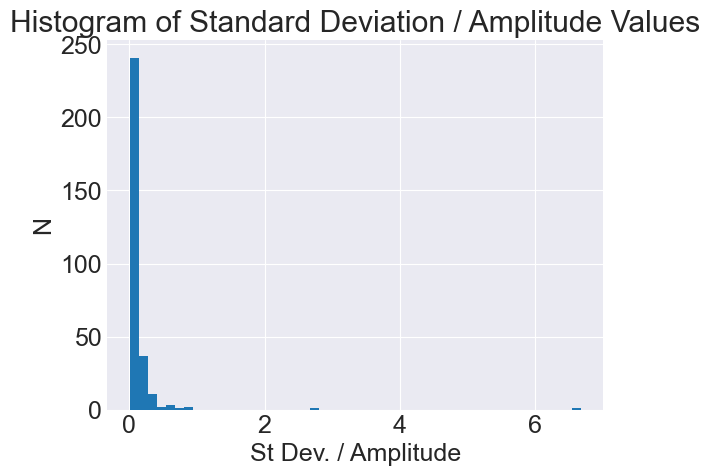

plotted lines 293 depths 293 fwhms 293
FINAL LENGTH OF DEPTH COUNTER IS 172
2460487.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


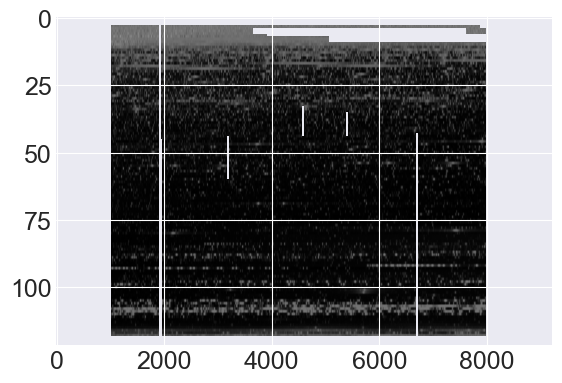

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.17538340802 5053.771950100791
window flux len is 52
maxes [ 2 20 45]
mins [11 32]
FWHM = 0.09485263134930219
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.06639409366 8337.671465859223
window flux len is 44
maxes [38]
mins [26]
winner is 8337.6012130547
FWHM = 0.42222152044983235
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.324870231965 9605.925157550035
window flux len is 33
***** No maxima found, line 9605.618031381042 skipped *****
*** Index is 8, line is 

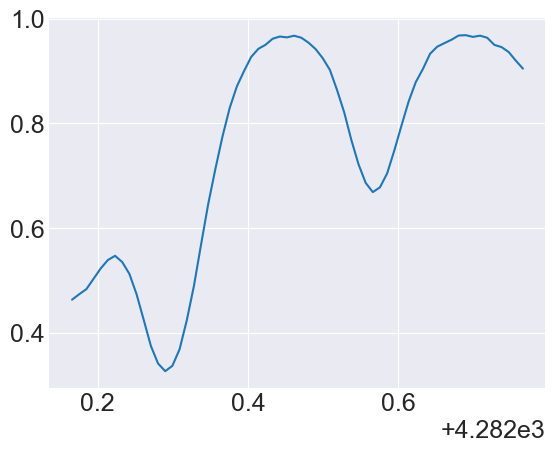

maxes [ 6 29 31 55 57]
mins [13 30 42 56]
FWHM = 0.17189899381481985
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.115941631027 4454.712608059326
window flux len is 69
maxes [ 1  3 29 32 36 66]
mins [ 2 14 31 35 50]
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.6335872212685 4514.229052732928
window flux len is 65
maxes [ 2  6  9 11 14 17 19 54]
mins [ 4  8 10 13 16 18 39]
winner is 4514.136176427645
FWHM = 0.09400506034289849
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.158058288857 4618.755311044504
window flux len is 65
maxes [ 1  4  7  9 13 16 20 22 26 28 57 61 63]
mins [ 3  5  8 11 14 19 21 25 27 43 59 62]
winner is 4618.690111244185
FWHM = 0.10042694248306573
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds are 4657.366497597826 4657.9681399

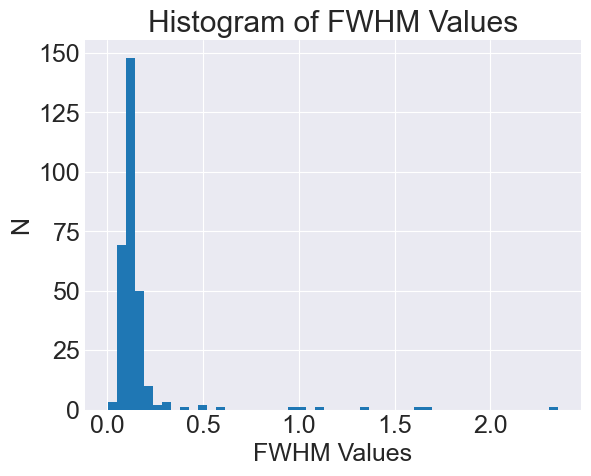

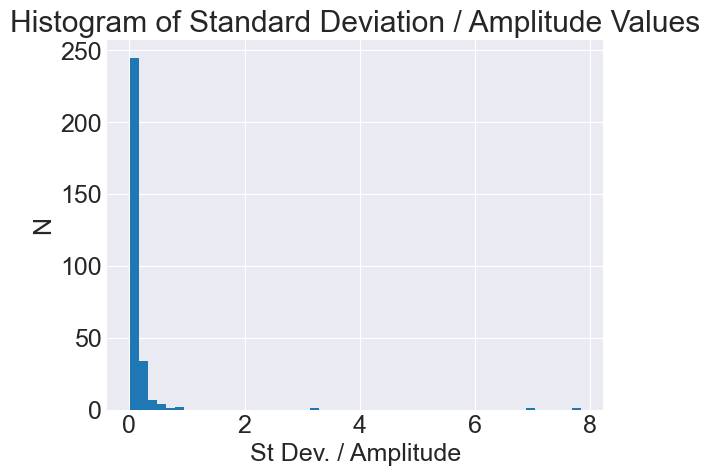

plotted lines 290 depths 290 fwhms 290
FINAL LENGTH OF DEPTH COUNTER IS 172
2460489.0
(122, 9216)


/var/folders/pd/7z6jy20x3gv907tc5hf714300000gn/T/ipykernel_67515/2751827891.py:14: RuntimeWarning: All-NaN slice encountered
  temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])


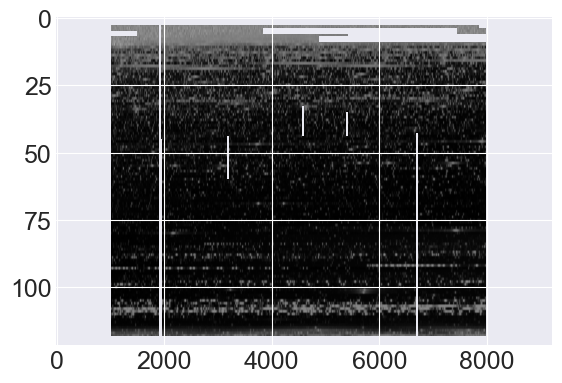

Blaze correct OFF
***** LEFT/RIGHT MAXIMAS NOT PROVIDED *****
*** Index is 0, line is 6709.52869740875 ***
Did not make depth cut
*** Index is 1, line is 4818.6133257562315 ***
Did not make depth cut
*** Index is 2, line is 5053.477338234851 ***
wavelength bounds are 5053.175795076317 5053.772361817689
window flux len is 52
maxes [ 3 20 46]
mins [11 32]
FWHM = 0.09716710740039226
*** Index is 3, line is 5381.766813962966 ***
Did not make depth cut
*** Index is 4, line is 6589.3959550438085 ***
Did not make depth cut
*** Index is 5, line is 7115.0392199407515 ***
Did not make depth cut
*** Index is 6, line is 8337.372368849545 ***
wavelength bounds are 8337.067083772366 8337.672152563735
window flux len is 44
maxes [ 1 39]
mins [26]
winner is 8337.615952791011
FWHM = 0.38415140167502115
*** Index is 7, line is 9605.618031381042 ***
wavelength bounds are 9605.32563681874 9605.925923451898
window flux len is 33
***** No maxima found, line 9605.618031381042 skipped *****
*** Index is 8, li

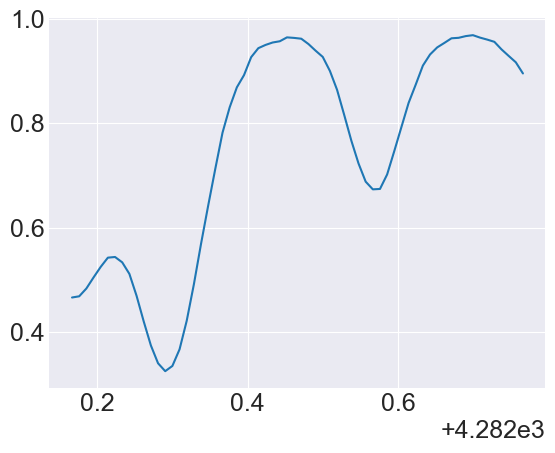

maxes [ 6 30 56]
mins [13 42]
FWHM = 0.1712571043541967
*** Index is 82, line is 4442.410791322856 ***
Did not make depth cut
*** Index is 83, line is 4454.414062827551 ***
wavelength bounds are 4454.116304495599 4454.712970972507
window flux len is 69
maxes [ 1 30 34 66]
mins [15 31 50]
winner is 4454.695461640896
FWHM = 1.9672343144604607
*** Index is 84, line is 4513.930284039112 ***
wavelength bounds are 4513.6339549345785 4514.22942049475
window flux len is 65
maxes [ 5  7  9 12 17 19 22 53 55]
mins [ 6  8 10 16 18 21 39 54]
winner is 4514.127253186218
FWHM = 0.09414873897646871
*** Index is 85, line is 4563.843888047776 ***
Did not make depth cut
*** Index is 86, line is 4618.4587733969265 ***
wavelength bounds are 4618.15843451749 4618.755687321792
window flux len is 65
maxes [ 1  3  5  7 10 12 17 21 24 28 58 61 63]
mins [ 2  4  6  8 11 16 20 23 26 43 59 62]
winner is 4618.699803649342
FWHM = 0.10004440985611249
*** Index is 87, line is 4657.6694603148835 ***
wavelength bounds a

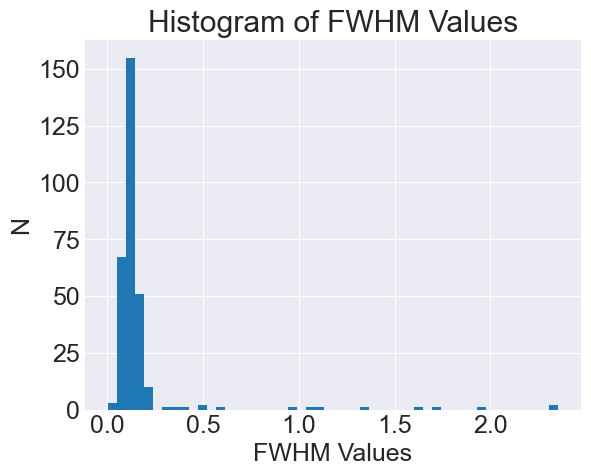

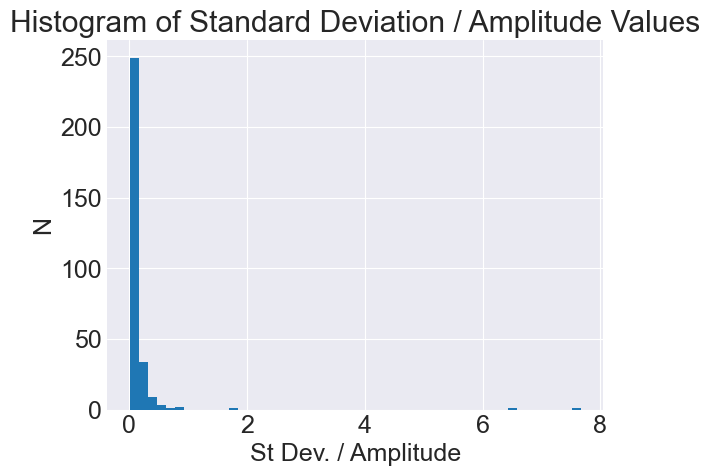

plotted lines 293 depths 293 fwhms 293
FINAL LENGTH OF DEPTH COUNTER IS 172


In [42]:
#Read in templates and loop through
    # save each template to .csv file


for run, unique in enumerate(uniques):
    print(unique)
    # read in template
    templatePath = os.path.join(local_path, f'test_temp{unique}.csv')
    template = np.loadtxt(open(templatePath, "rb"), delimiter=",")

    temp_to_plot = template
    print(np.shape(temp_to_plot))
    for n in range(0,len(template)-1):
        temp_to_plot[n] = temp_to_plot[n] / np.nanmax(temp_to_plot[n])

    # read in masterwave
    masterwavePath = os.path.join(local_path, f'test_wave{unique}.csv')
    masterwave = np.loadtxt(open(masterwavePath, "rb"), delimiter=",")
    
    plt.imshow(temp_to_plot,aspect=50)
    plt.show()
    
    #cut wavelengths outside of the neid range
    dict_linelist['lambda (nm) '] = dict_linelist['lambda (nm) '].astype(float)
    dict_linelist = dict_linelist[(dict_linelist['lambda (nm) '] > 357.09) & (dict_linelist['lambda (nm) '] < 1125.1)]
    line_wls_nm = np.asarray(dict_linelist['lambda (nm) '])
    cent_line_depth = np.asarray(dict_linelist[' depth '])
    full_species = np.asarray(dict_linelist[' element '])

    #prep arrays to create maxima boundary dictionary
    left_maximas = []
    right_maximas = []
    maxima_dictx = {}   

    #run pipeline
    flux = template
    wavelengths = masterwave * 10
    obs_jd = unique
    if len(wavelengths) != 0:
        results = compare_lines1(run, line_list, wavelengths, flux, obs_jd, maxima_dict=maxima_dictx, blaze_correct=False, vac=False)